In [88]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from matplotlib.image import imread
import seaborn as sns
import random
import cv2
import copy

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transform
import torchvision.models as models
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
from torch.utils.data import random_split, DataLoader
import splitfolders

from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

import os

# Data Visualization & Preprocessing

In [57]:
data_dir = 'mri_brain'


print(os.listdir(data_dir))


['Healthy', 'Brain Tumor']


Let's work with fewer data points to get a hand on our ideas.

In [58]:
import os
import shutil
import random

source_dir = 'mri_brain'  
target_dir = 'mri_brain_reduced' 
categories = ['Healthy', 'Brain Tumor']
n_images = 30

for cat in categories:
    os.makedirs(os.path.join(target_dir, cat), exist_ok=True)
    
    source_path = os.path.join(source_dir, cat)
    images = os.listdir(source_path)
    
    ## Random selection of images
    random.seed(42) ## For reproducibility
    selected_images = random.sample(images, n_images)
    
    # Copy of the images
    for img_name in selected_images:
        src = os.path.join(source_path, img_name)
        dst = os.path.join(target_dir, cat, img_name)
        shutil.copy(src, dst)

print(f"Folder {target_dir} created with {n_images} images per category.")

Folder mri_brain_reduced created with 30 images per category.


In [59]:
data_dir_reduced = 'mri_brain'
splitfolders.ratio(data_dir_reduced, output="mri_brain_sorted", 
                   seed=42, ratio=(.8, .1, .1), 
                   group_prefix=None, move=False)

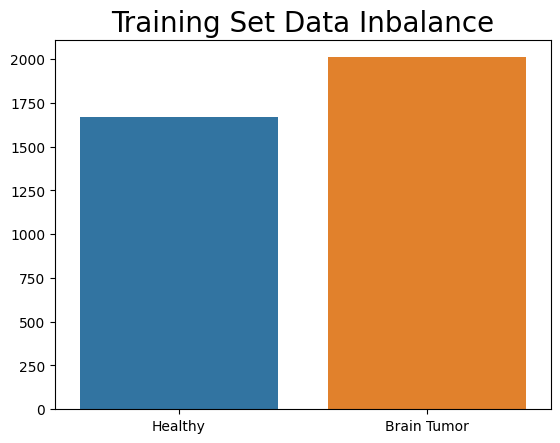

In [60]:
data_dir_sorted = 'mri_brain_sorted'
test_samplesize = pd.DataFrame.from_dict(
    {'Healthy': [len([os.path.join(data_dir_sorted+'/train/Healthy', filename) 
                     for filename in os.listdir(data_dir_sorted+'/train/Healthy')])], 
     'Brain Tumor': [len([os.path.join(data_dir_sorted+'/train/Brain Tumor', filename) 
                        for filename in os.listdir(data_dir_sorted+'/train/Brain Tumor')])]})


sns.barplot(data=test_samplesize).set_title('Training Set Data Inbalance', fontsize=20)
plt.show()

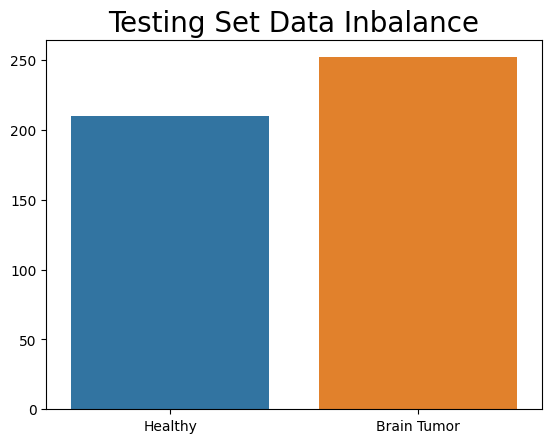

In [61]:
data_dir_sorted = 'mri_brain_sorted'
test_samplesize = pd.DataFrame.from_dict(
    {'Healthy': [len([os.path.join(data_dir_sorted+'/test/Healthy', filename) 
                     for filename in os.listdir(data_dir_sorted+'/test/Healthy')])], 
     'Brain Tumor': [len([os.path.join(data_dir_sorted+'/test/Brain Tumor', filename) 
                        for filename in os.listdir(data_dir_sorted+'/test/Brain Tumor')])]})


sns.barplot(data=test_samplesize).set_title('Testing Set Data Inbalance', fontsize=20)
plt.show()

In [62]:
train_dataset = ImageFolder(data_dir_sorted+'/train', 
                      transform=transform.Compose([transform.Resize(255),
                                            transform.CenterCrop(224),
                                            transform.RandomHorizontalFlip(),
                                            transform.RandomRotation(10),
                                            transform.RandomGrayscale(),
                                            transform.RandomAffine(translate=(0.05,0.05), degrees=0),
                                            transform.ToTensor()
                                            #tt.Normalize(mean=[0.485, 0.456, 0.406], 
                                            #std=[0.229, 0.224, 0.225] ,inplace=True)
                                           ]))


In [63]:
train_dataset

Dataset ImageFolder
    Number of datapoints: 3679
    Root location: mri_brain_sorted/train
    StandardTransform
Transform: Compose(
               Resize(size=255, interpolation=bilinear, max_size=None, antialias=True)
               CenterCrop(size=(224, 224))
               RandomHorizontalFlip(p=0.5)
               RandomRotation(degrees=[-10.0, 10.0], interpolation=nearest, expand=False, fill=0)
               RandomGrayscale(p=0.1)
               RandomAffine(degrees=[0.0, 0.0], translate=(0.05, 0.05))
               ToTensor()
           )

In [89]:
test_dataset = ImageFolder(data_dir_sorted+'/test', 
                           transform=transform.Compose([transform.Resize(255),
                                                 transform.CenterCrop(224),                                                              
                                                 transform.ToTensor()
                                                 #tt.Normalize(mean=[0.485, 0.456, 0.406], 
                                                 #             std=[0.229, 0.224, 0.225],
                                                 #             inplace=True)
                                                ]))

test_dl = DataLoader(test_dataset, batch_size=256)


In [90]:
batch_size=4

train_dl=DataLoader(train_dataset,batch_size,shuffle=True,pin_memory=True)

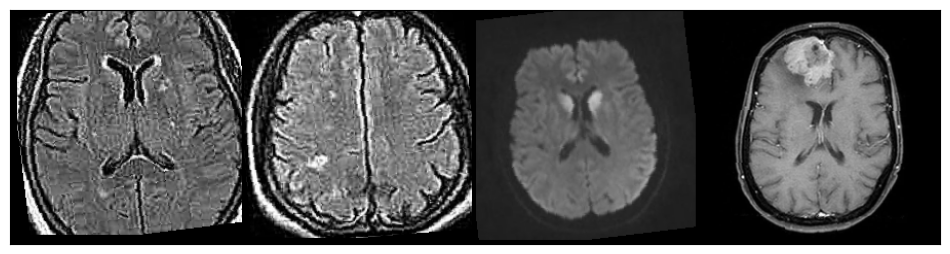

In [91]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images[:60], nrow=10).permute(1, 2, 0))
        break
        
show_batch(train_dl)

# Model

In [67]:
def train_accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1) 
    return torch.sum(preds == labels).item() / len(preds)

def F1_score(outputs, labels):
    _, preds = torch.max(outputs, dim=1) 
    
    # precision, recall, and F1
    cm  = confusion_matrix(labels, preds)
    tn, fp, fn, tp = cm.ravel()
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    f1 = 2*((precision*recall)/(precision+recall))
    
    return precision,recall,f1,preds

In [92]:
class BrainTumorResNet(nn.Module):
    def __init__(self):
        super().__init__()
        # Use a pretrained model
        self.network = models.resnet50(pretrained=True)
        # Freeze training for all layers before classifier
        for param in self.network.fc.parameters():
            param.require_grad = False  
        num_features = self.network.fc.in_features # get number of in features of last layer
        self.network.fc = nn.Linear(num_features, 2) # replace model classifier
    
    def forward(self, xb):
        out=self.network(xb)
        return out   

In [18]:
#define number of epochs
n=10

# #define dataset
# batch_size=4
# train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=0, pin_memory=True)
# val_dl = DataLoader(val_ds, batch_size*2, shuffle = True, num_workers=0, pin_memory=True)

#define model
model = BrainTumorResNet() ##.cuda() to use GPU

#define loss function
criterion = nn.CrossEntropyLoss()

#define optimizer
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)

#define scheduler
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma = 0.9)

#define history
history={}
for epoch in range(n):
    print(f"Epoch n°{epoch+1}")

    #Training step 

    train_accs=[]
    losses = []

    for input, target in train_dl:
        #clear all gradients
        optimizer.zero_grad()

        #feed data into model
        pred = model(input)##.cuda() to use GPU
        
        #calculate loss
        loss = criterion(pred,target)
        losses.append(loss.detach())

        #calculate all gradients
        loss.backward()

        #backforward propagation and update network
        optimizer.step()

        #accuracy
        acc=train_accuracy(pred,target)
        train_accs.append(acc)

    #adjust learning rate
    scheduler.step()

    #print accuracy and loss
    train_acc=np.array(train_accs).sum()/len(train_accs)
    train_loss=torch.stack(losses).mean()

    print(f"Training accuracy : {train_acc}")
    print(f"Training loss : {train_loss}")


    # #Validation step
    # model.eval()
    # val_infos=[]

    # for input, target in val_dl:
    #     pred=model(input)
    #     loss=criterion(pred,target)
    #     acc=train_accuracy(pred,target)
    #     val_info={'val_loss' : loss.detach(), 'val_acc' : acc}
    #     val_infos.append(val_info)
    
    # batch_losses = [x['val_loss'] for x in val_infos]         # get all the batches loss
    # val_loss = torch.stack(batch_losses).mean()           # combine losses
    # batch_accs = [x['val_acc'] for x in val_infos]            # get all the batches acc
    # val_acc = np.array(batch_accs).sum()/len(batch_accs)              # combine accuracies
    
    # print(f"Valuation loss : {val_loss.item()}")
    # print(f"Valuation accuracy : {val_acc.item()}")

    # # save results to dictionary
    # to_add = {'train_loss': train_loss,
    #             'train_acc': train_acc,
    #             'val_loss': val_loss,
    #             'val_acc': val_acc}
    
    # # update performance dictionary
    # for key,val in to_add.items():
    #     if key in history:
    #         history[key].append(val)
    #     else:
    #         history[key] = [val]

/Users/mathildebodet/Desktop/centrale/3A/Deep Learning/Pneumonia-Detection/venv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/mathildebodet/Desktop/centrale/3A/Deep Learning/Pneumonia-Detection/venv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /Users/mathildebodet/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100.0%


Epoch n°1
Training accuracy : 0.8654891304347826
Training loss : 0.3541017174720764
Epoch n°2
Training accuracy : 0.9567934782608696
Training loss : 0.13980354368686676
Epoch n°3
Training accuracy : 0.9665760869565218
Training loss : 0.1056000366806984
Epoch n°4
Training accuracy : 0.977445652173913
Training loss : 0.06598875671625137
Epoch n°5
Training accuracy : 0.9826086956521739
Training loss : 0.053725820034742355
Epoch n°6
Training accuracy : 0.9875
Training loss : 0.03651721775531769
Epoch n°7
Training accuracy : 0.9896739130434783
Training loss : 0.03358320891857147
Epoch n°8
Training accuracy : 0.9923913043478261
Training loss : 0.02940516546368599
Epoch n°9
Training accuracy : 0.9940217391304348
Training loss : 0.02177838422358036
Epoch n°10
Training accuracy : 0.9951086956521739
Training loss : 0.02025340124964714


In [19]:
preds = []
targets = []

model.eval()
with torch.no_grad():
    for input, target in test_dl:
        # Transfert sur le GPU si vous en utilisez un (conseillé)
        # input = input.to(device) 
        
        pred = model(input)
        
        # On récupère l'indice de la classe maximale
        pred_binary = torch.argmax(pred, dim=1)
        
        # .extend() ajoute chaque élément individuellement à la liste
        preds.extend(pred_binary.cpu().numpy().tolist())
        targets.extend(target.cpu().numpy().tolist())

# Vérification : la taille doit être égale au nombre total d'images de test
print(f"Nombre de prédictions : {len(preds)}")

Nombre de prédictions : 462


In [20]:
def test_accuracy(output, target):
    output = torch.tensor(np.array(output)).float()
    target = torch.tensor(np.array(target)).float()
    
    predicted = (output >= 0.5).float()
    
    correct = (predicted == target).sum().item()
    

    accuracy = correct / len(target)
    
    return accuracy

acc = test_accuracy(preds, targets)
print(f"Accuracy: {acc:.4f}")

Accuracy: 0.9870


<Figure size 640x480 with 0 Axes>

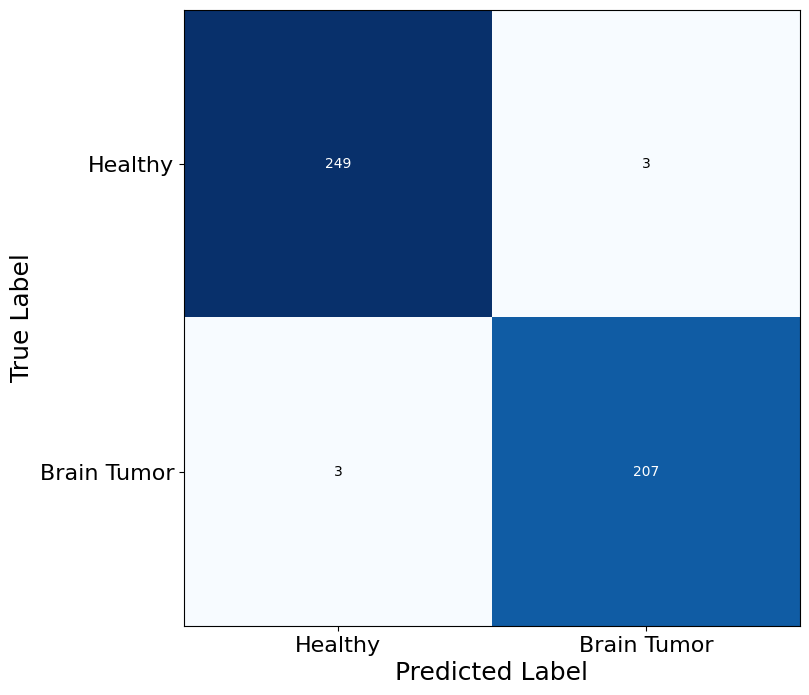

In [21]:
plt.figure()

cm = confusion_matrix(targets, preds)

plot_confusion_matrix(cm, figsize=(12,8), cmap=plt.cm.Blues)

plt.xticks(range(2), ['Healthy', 'Brain Tumor'], fontsize=16)
plt.yticks(range(2), ['Healthy', 'Brain Tumor'], fontsize=16)

plt.xlabel('Predicted Label', fontsize=18)
plt.ylabel('True Label', fontsize=18)
plt.show()

In [22]:
# Compute Performance Metrics
tn, fp, fn, tp = cm.ravel()

accuracy = (np.array(preds) == np.array(targets)).sum() / len(preds)

precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
f1 = 2 * ((precision * recall) / (precision + recall)) if (precision + recall) > 0 else 0

print("Accuracy of the model is {:.2f}".format(accuracy))
print("Recall of the model is {:.2f}".format(recall))
print("Precision of the model is {:.2f}".format(precision))
print("F1 Score of the model is {:.2f}".format(f1))

Accuracy of the model is 0.99
Recall of the model is 0.99
Precision of the model is 0.99
F1 Score of the model is 0.99


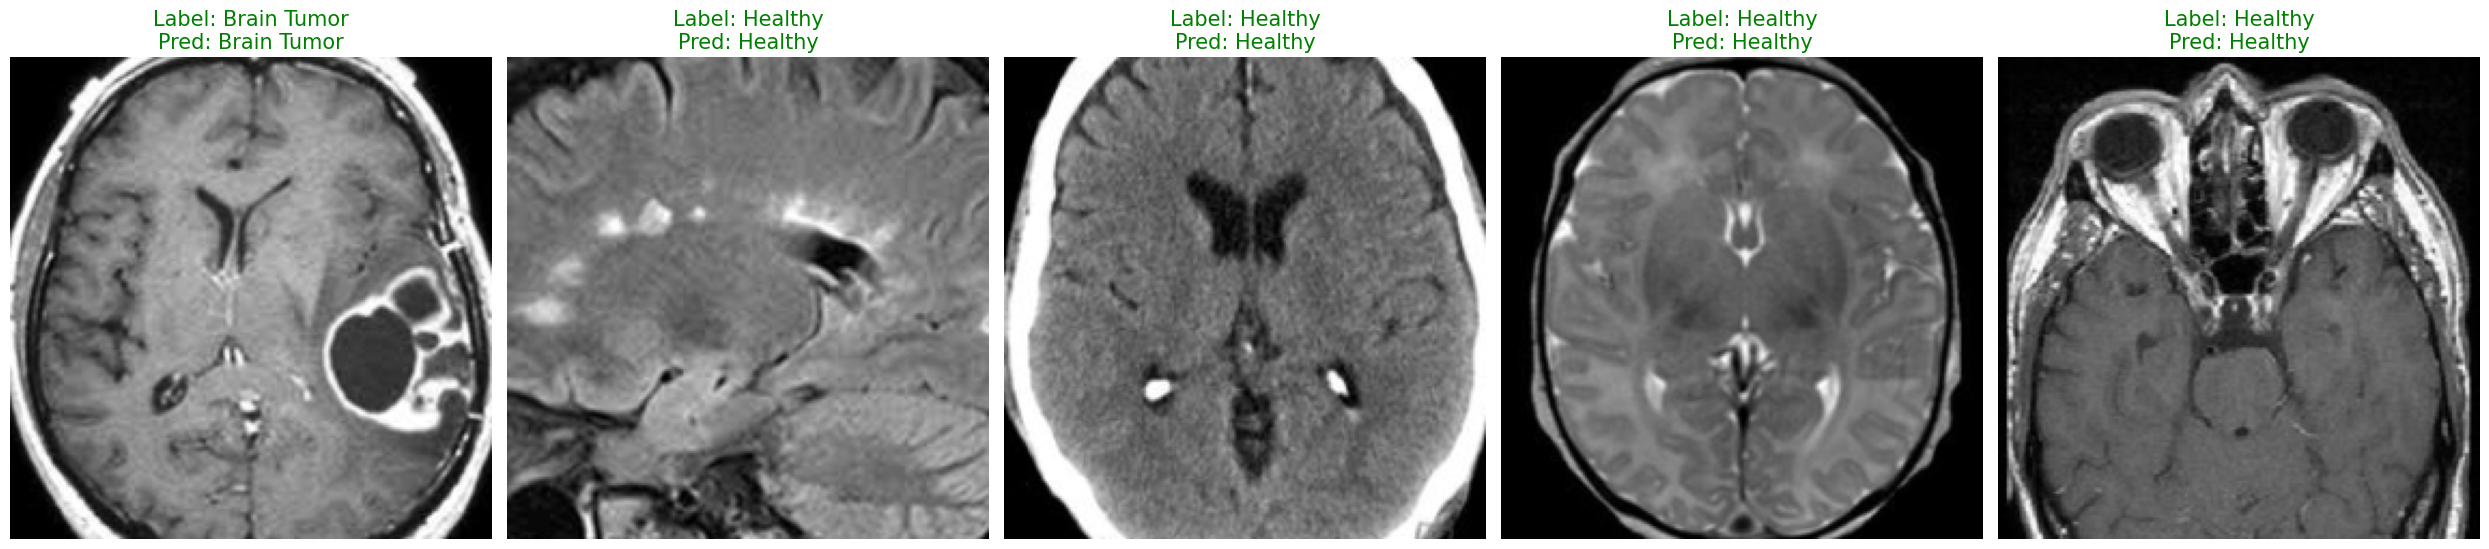

In [23]:
num_images = 5
idxs = random.sample(range(len(test_dataset)), num_images)

fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(25, 7))

for c, i in enumerate(idxs):
    img_tensor, label = test_dataset[i]
    
    ax[c].imshow(img_tensor[0, :, :], cmap='gray')
    
    actual_label = test_dataset.classes[label]
    predicted_label = test_dataset.classes[preds[i]] 
    
    ax[c].set_title(f'Label: {actual_label}\nPred: {predicted_label}', 
                    fontsize=15, 
                    color=('green' if actual_label == predicted_label else 'red'))
    
    ax[c].axis('off')

plt.tight_layout()
plt.show()

In [16]:
class BrainTumorConvNeXt(nn.Module):
    def __init__(self):
        super().__init__()
        # Use a pretrained model
        self.network = models.convnext_base(weights='IMAGENET1K_V1')
        # Geler l'entraînement de toutes les couches avant le classifieur
        for param in self.network.parameters():
            param.requires_grad = False

        # Obtenir la dernière couche du classifieur
        modules = list(self.network.modules())
        last_layer = None
        for module in reversed(modules):
            if isinstance(module, nn.Linear):
                last_layer = module
                break

        # Vérifier si une dernière couche linéaire a été trouvée
        if last_layer is not None:
            # Obtenir le nombre de fonctionnalités en entrée de la dernière couche
            num_features = last_layer.in_features

            # Remplacer la dernière couche par une nouvelle couche linéaire avec deux sorties
            self.network.classifier[2] = nn.Linear(num_features, 2)
    
    def forward(self, xb):
        out=self.network(xb)
        out = F.softmax(out, dim=1)
        return out   

In [ ]:
#define number of epochs
import torch, time, gc
n=10

torch.set_num_threads(4)
# #define dataset
batch_size=4
#train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=0, pin_memory=True)
#val_dl = DataLoader(val_ds, batch_size*2, num_workers=0, pin_memory=True)

#define model
model_conv = BrainTumorConvNeXt()

#define loss function
criterion = nn.CrossEntropyLoss()

#define optimizer
optimizer = torch.optim.AdamW(model_conv.parameters(), lr = 0.0004)

#define scheduler
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma = 0.9)

#define history
history={}
for epoch in range(n):
    start = time.time()
    
    print(f"Epoch n°{epoch+1}")

    #Training step 

    train_accs=[]
    losses = []

    for input, target in train_dl:
        #clear all gradients
        optimizer.zero_grad()

        #feed data into model
        pred = model_conv(input)##.cuda() to use GPU
        
        #calculate loss
        loss = criterion(pred,target)
        losses.append(loss.detach())

        #calculate all gradients
        loss.backward()

        #backforward propagation and update network
        optimizer.step()

        #accuracy
        acc=train_accuracy(pred,target)
        train_accs.append(acc)

    #adjust learning rate
    scheduler.step()

    #print accuracy and loss
    train_acc=np.array(train_accs).sum()/len(train_accs)
    train_loss=torch.stack(losses).mean()

    print(f"Training accuracy : {train_acc}")
    print(f"Training loss : {train_loss}")

    save_path = f"checkpoint_convnext_epoch_{epoch+1}.pth"

    # convert to float16 to reduce file size / faster saving
    state_dict = {k: v.half() for k, v in model_conv.state_dict().items()}

    torch.save(state_dict, save_path)

    print(f"--> Weights saved to {save_path}")

    # time feedback
    duration = time.time() - start
    print(f"Epoch duration: {duration:.2f} seconds")

torch.save(history, "convnext_history.pt")
    # clean cpu memory
gc.collect()
    
    # #Validation step
    # model.eval()
    # val_infos=[]

    # for input, target in val_dl:
    #     pred=model(input)
    #     loss=criterion(pred,target)
    #     acc=train_accuracy(pred,target)
    #     val_info={'val_loss' : loss.detach(), 'val_acc' : acc}
    #     val_infos.append(val_info)
    
    # batch_losses = [x['val_loss'] for x in val_infos]         # get all the batches loss
    # val_loss = torch.stack(batch_losses).mean()           # combine losses
    # batch_accs = [x['val_acc'] for x in val_infos]            # get all the batches acc
    # val_acc = np.array(batch_accs).sum()/len(batch_accs)              # combine accuracies
    
    # print(f"Valuation loss : {val_loss.item()}")
    # print(f"Valuation accuracy : {val_acc.item()}")

    # # save results to dictionary
    # to_add = {'train_loss': train_loss,
    #             'train_acc': train_acc,
    #             'val_loss': val_loss,
    #             'val_acc': val_acc}
    
    # # update performance dictionary
    # for key,val in to_add.items():
    #     if key in history:
    #         history[key].append(val)
    #     else:
    #         history[key] = [val]

Epoch n°1
Training accuracy : 0.8144021739130435
Training loss : 0.5312929749488831
--> Weights saved to checkpoint_convnext_epoch_1.pth
Epoch duration: 1943.42 seconds
Epoch n°2
Training accuracy : 0.8782608695652174
Training loss : 0.46111389994621277
--> Weights saved to checkpoint_convnext_epoch_2.pth
Epoch duration: 7224.02 seconds
Epoch n°3
Training accuracy : 0.8994565217391305
Training loss : 0.43636074662208557
--> Weights saved to checkpoint_convnext_epoch_3.pth
Epoch duration: 6949.44 seconds
Epoch n°4
Training accuracy : 0.9127717391304347
Training loss : 0.4289250671863556
--> Weights saved to checkpoint_convnext_epoch_4.pth
Epoch duration: 28396.11 seconds
Epoch n°5


KeyboardInterrupt: 

In [ ]:
preds_conv = []
targets_conv = []

model_conv.eval()
with torch.no_grad():

    for input, target in test_dl:
        
        pred = model_conv(input)
        
        pred_binary = torch.argmax(pred, dim=1)
        
        preds_conv.extend(pred_binary.cpu().numpy().tolist())
        targets_conv.extend(target.cpu().numpy().tolist())

# Verify that the size matches the total number of test images
print(f"Number of predictions : {len(preds_conv)}")

Nombre de prédictions : 18


<Figure size 640x480 with 0 Axes>

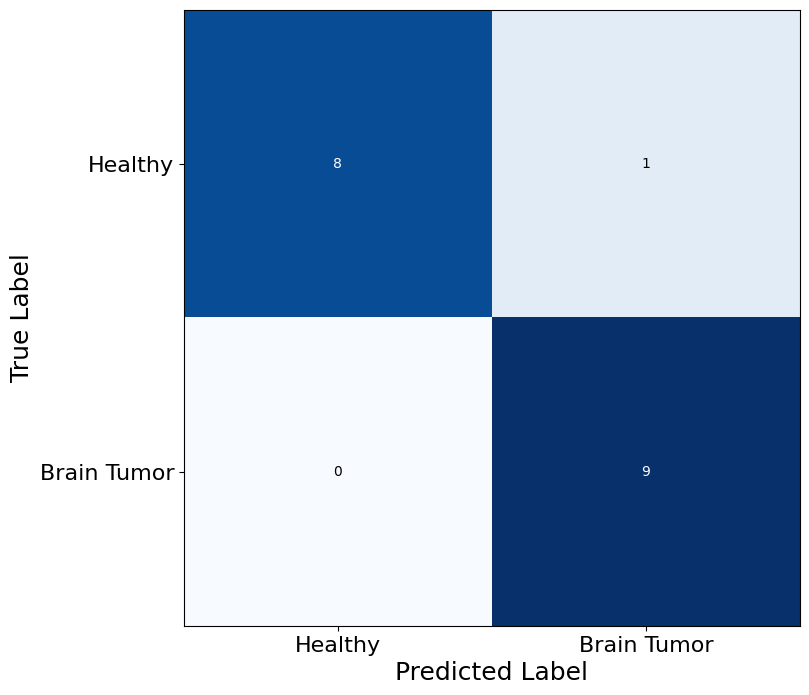

In [ ]:
plt.figure()

cm_conv = confusion_matrix(targets_conv, preds_conv)

plot_confusion_matrix(cm_conv, figsize=(12,8), cmap=plt.cm.Blues)

plt.xticks(range(2), ['Healthy', 'Brain Tumor'], fontsize=16)
plt.yticks(range(2), ['Healthy', 'Brain Tumor'], fontsize=16)

plt.xlabel('Predicted Label', fontsize=18)
plt.ylabel('True Label', fontsize=18)
plt.show()

In [ ]:
# Compute Performance Metrics
tn, fp, fn, tp = cm.ravel()

accuracy = (np.array(preds_conv) == np.array(targets_conv)).sum() / len(preds_conv)

precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
f1 = 2 * ((precision * recall) / (precision + recall)) if (precision + recall) > 0 else 0

print("Accuracy of the model is {:.2f}".format(accuracy))
print("Recall of the model is {:.2f}".format(recall))
print("Precision of the model is {:.2f}".format(precision))
print("F1 Score of the model is {:.2f}".format(f1))

Accuracy of the model is 0.94
Recall of the model is 1.00
Precision of the model is 0.90
F1 Score of the model is 0.95


In [ ]:
acc_conv = test_accuracy(preds_conv, targets_conv)
print(f"Accuracy: {acc_conv:.4f}")

Accuracy: 0.9444


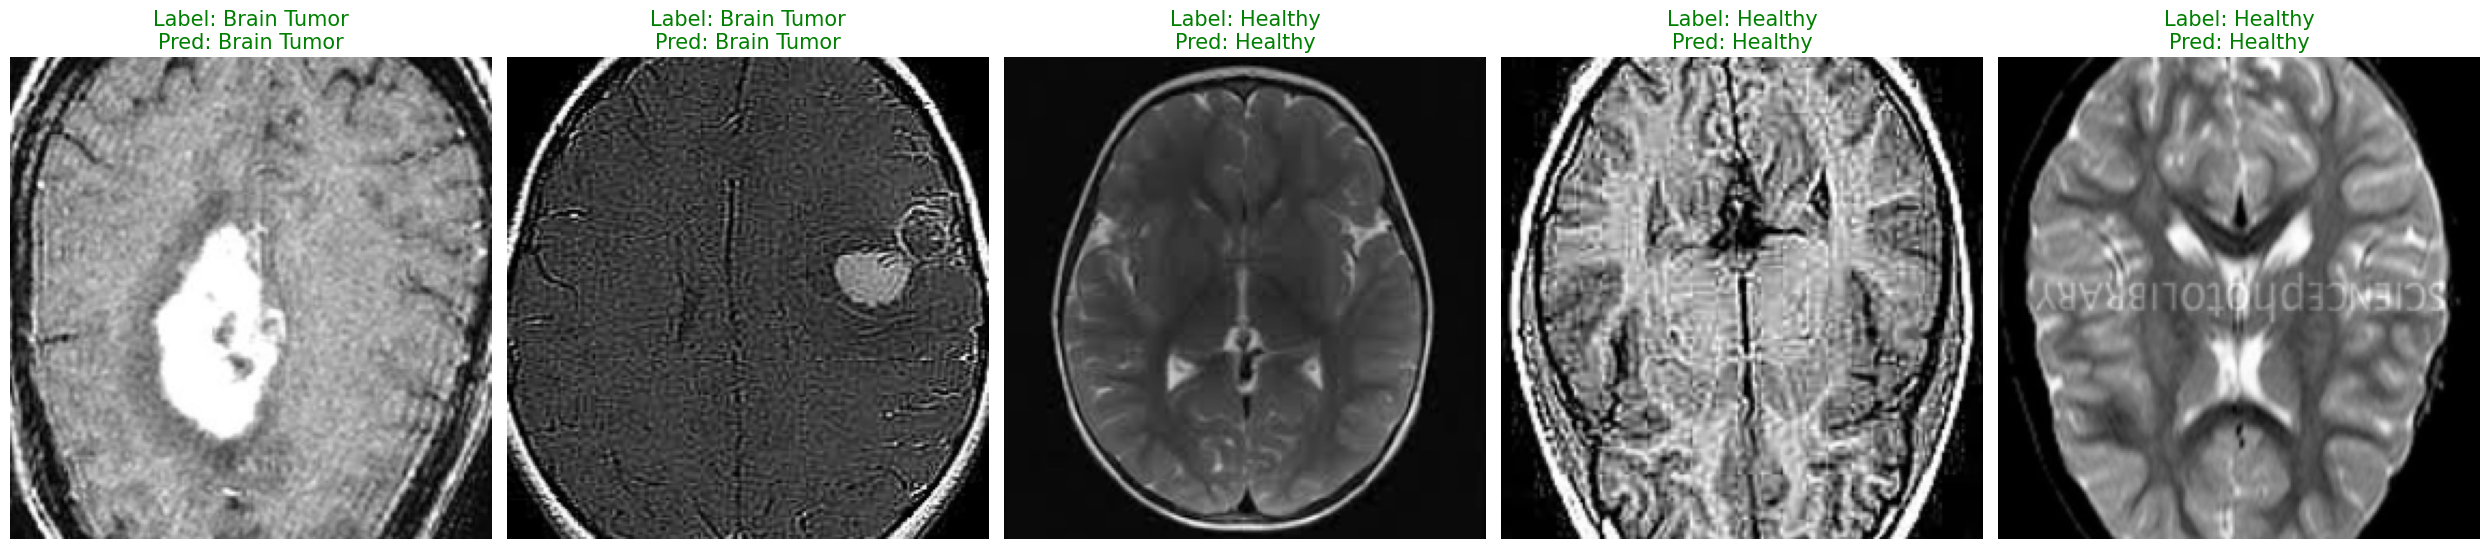

In [ ]:
num_images = 5
idxs = random.sample(range(len(test_dataset)), num_images)

fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(25, 7))

for c, i in enumerate(idxs):
    img_tensor, label = test_dataset[i]
    
    ax[c].imshow(img_tensor[0, :, :], cmap='gray')
    
    actual_label = test_dataset.classes[label]
    predicted_label = test_dataset.classes[preds_conv[i]] 
    
    ax[c].set_title(f'Label: {actual_label}\nPred: {predicted_label}', 
                    fontsize=15, 
                    color=('green' if actual_label == predicted_label else 'red'))
    
    ax[c].axis('off')

plt.tight_layout()
plt.show()

## Comparaison entre Bruit Gaussien et Bruit Ricien

In [112]:
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=0.05):
        self.std = std
        self.mean = mean
    def __call__(self, tensor):
        noise_shape = [1, tensor.size(1), tensor.size(2)]
        
        n = torch.randn(noise_shape) * self.std
        
        return tensor + n + self.mean

class AddRicianNoise(object):
    """
    Ajoute un bruit de Rice standard.
    Formule : sqrt((I + n_re)^2 + n_im^2)
    """
    def __init__(self, sigma=0.01):
        self.sigma = sigma

    def __call__(self, tensor):
        noise_shape = [1, tensor.size(1), tensor.size(2)]
        
        n_re = torch.randn(noise_shape) * self.sigma
        n_im = torch.randn(noise_shape) * self.sigma
        
        # Application de la formule standard de la magnitude
        # Le bruit se diffuse sur les 3 canaux (R,G,B) de manière identique
        noisy = torch.sqrt((tensor + n_re)**2 + n_im**2)
        
        return noisy

In [113]:
# Taille standard pour ResNet et ConvNeXt
img_size = 224

# Transformations de base (sans bruit)
base_transform = transform.Compose([transform.Resize(255),
                                            transform.CenterCrop(224),
                                            transform.RandomHorizontalFlip(),
                                            transform.RandomRotation(10),
                                            transform.RandomAffine(translate=(0.05,0.05), degrees=0),
                                            transform.ToTensor()
])

# Normalisation (à appliquer APRES le bruit)
# On utilise les statistiques ImageNet
normalize = transform.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

In [114]:
sigma = 0.1

# SCÉNARIO 1 : Baseline (Standard)
train_transform_baseline = transform.Compose([
    base_transform,
    normalize
])

# SCÉNARIO 2 : Bruit Gaussien
train_transform_gaussian = transform.Compose([
    base_transform,
    AddGaussianNoise(std=sigma), # Sigma de 0.05 est un bon point de départ
    normalize
])

# SCÉNARIO 3 : Bruit de Rice
train_transform_rician = transform.Compose([
    base_transform,
    AddRicianNoise(sigma=sigma), # Même intensité pour comparer équitablement
    normalize
])

# Transformation de TEST (Toujours sans bruit !)
test_transform = transform.Compose([
    transform.Resize((img_size, img_size)),
    transform.ToTensor(),
    normalize
])

In [115]:
data_dir_sorted = 'mri_brain_sorted' 

# --- DATASETS ---

# Entraînement : Les 3 scénarios avec leurs bruits respectifs
train_ds_base = ImageFolder(os.path.join(data_dir_sorted, 'train'), transform=train_transform_baseline)
train_ds_gauss = ImageFolder(os.path.join(data_dir_sorted, 'train'), transform=train_transform_gaussian)
train_ds_rice = ImageFolder(os.path.join(data_dir_sorted, 'train'), transform=train_transform_rician)

# Validation : Sans bruit pour comparer les modèles sur une base neutre
val_ds = ImageFolder(os.path.join(data_dir_sorted, 'val'), transform=test_transform)

# Test : Sans bruit pour l'évaluation finale
test_ds = ImageFolder(os.path.join(data_dir_sorted, 'test'), transform=test_transform)

# --- LOADERS ---

batch_size = 4 # Adapté pour vos tests locaux

train_loader_base = DataLoader(train_ds_base, batch_size=batch_size, shuffle=True)
train_loader_gauss = DataLoader(train_ds_gauss, batch_size=batch_size, shuffle=True)
train_loader_rice = DataLoader(train_ds_rice, batch_size=batch_size, shuffle=True)

# Pour la validation et le test, shuffle=False pour garder l'ordre des prédictions
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

print(f"Datasets chargés : {len(train_ds_base)} train, {len(val_ds)} val, {len(test_ds)} test")

Datasets chargés : 3679 train, 459 val, 462 test


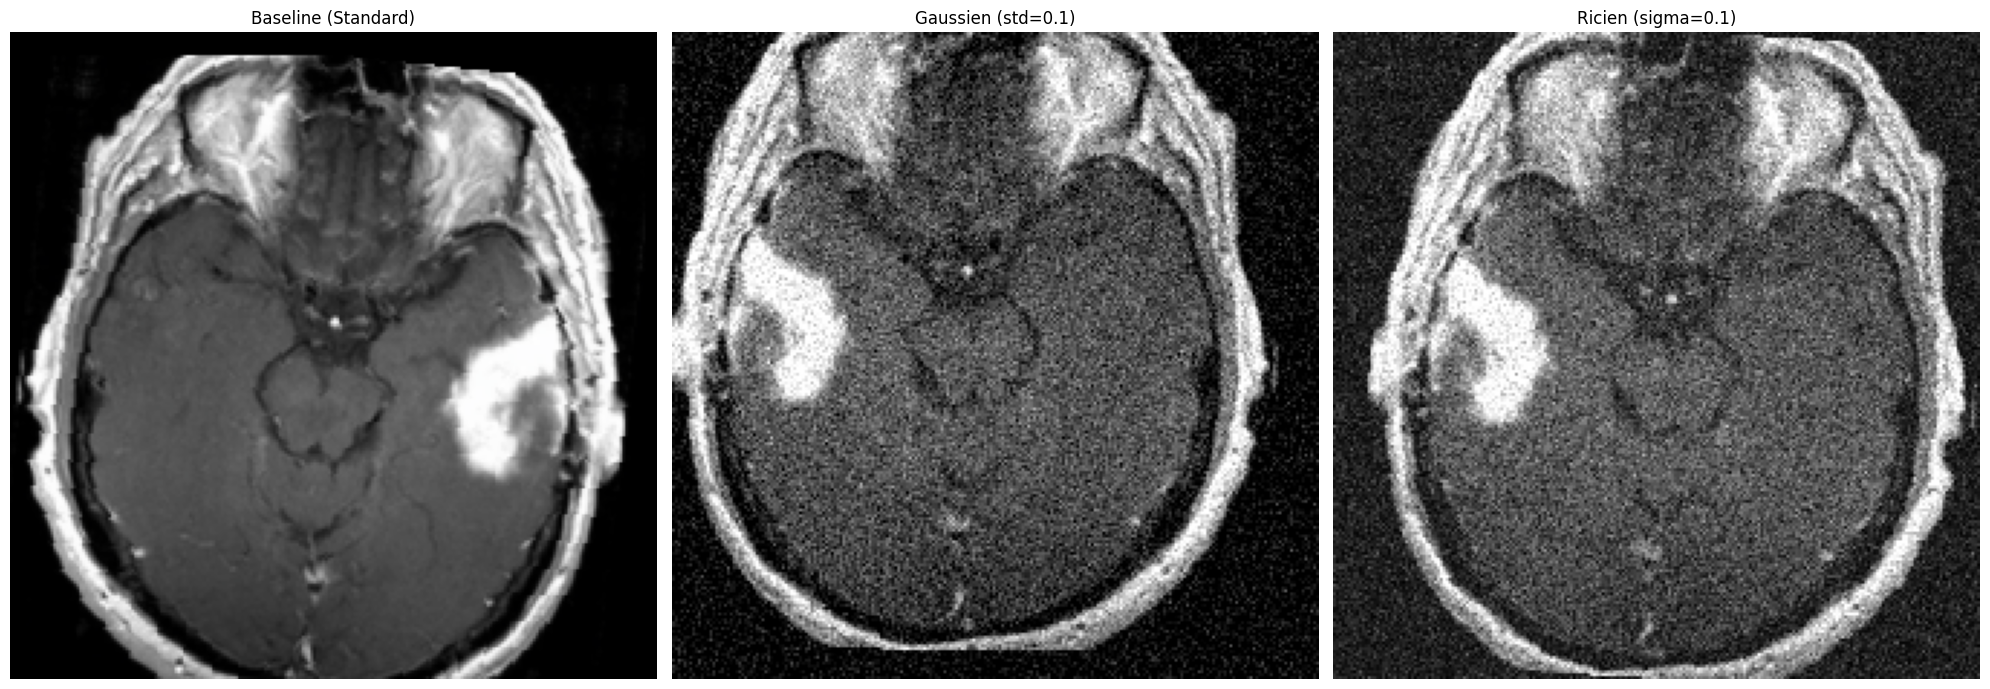

Valeur min (Base) : -2.1179 (Normalisée)
Valeur min (Gauss) : -4.0136 (Normalisée)
Valeur min (Rice) : -2.1083 (Normalisée)


In [116]:
def imshow_dataset(tensor, title=None):
    # 1. On déplace les dimensions de (C, H, W) vers (H, W, C)
    img = tensor.cpu().numpy().transpose((1, 2, 0))
    
    # 2. On annule la normalisation ImageNet
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean
    
    # 3. On force les valeurs entre 0 et 1 pour éviter les artefacts d'affichage
    img = np.clip(img, 0, 1)
    
    plt.imshow(img)
    if title:
        plt.title(title)
    plt.axis('off')

# On choisit un index d'image
idx = 4

# On récupère l'image de chaque dataset (déjà transformée)
img_base, label = train_ds_base[idx]
img_gauss, _ = train_ds_gauss[idx]
img_rice, _ = train_ds_rice[idx]

plt.figure(figsize=(20, 7))

# Affichage Baseline
plt.subplot(1, 3, 1)
imshow_dataset(img_base, "Baseline (Standard)")

# Affichage Gaussien
plt.subplot(1, 3, 2)
imshow_dataset(img_gauss, f"Gaussien (std={sigma})")

# Affichage Ricien
plt.subplot(1, 3, 3)
imshow_dataset(img_rice, f"Ricien (sigma={sigma})")

plt.tight_layout()
plt.show()

# Vérification numérique du fond pour confirmer le biais
print(f"Valeur min (Base) : {img_base.min():.4f} (Normalisée)")
print(f"Valeur min (Gauss) : {img_gauss.min():.4f} (Normalisée)")
print(f"Valeur min (Rice) : {img_rice.min():.4f} (Normalisée)")

In [95]:
import torch

# 1. On récupère un échantillon de l'image de base (après ToTensor, avant Normalize)
# On prend un coin de l'image (0:5, 0:5) qui est censé être le fond noir
sample_base, _ = train_ds_base[0]
pixels_base = sample_base[0, 0:5, 0:5] # Canal Rouge, bloc 5x5

# 2. On applique le bruit de Rice (avec votre classe actuelle)
rician_transformer = AddRicianNoise(sigma=0.01)
sample_rice = rician_transformer(sample_base)
pixels_rice = sample_rice[0, 0:5, 0:5] # Même bloc 5x5

print("--- VALEURS DES PIXELS (ZONE NOIRE) ---")
print("\nImage Originale (Base):")
print(pixels_base)

print("\nImage avec Bruit de Rice (Sigma=0.01):")
print(pixels_rice)

# Vérification statistique
print(f"\nMinimum Base: {pixels_base.min().item():.6f}")
print(f"Minimum Rice: {pixels_rice.min().item():.6f}")

--- VALEURS DES PIXELS (ZONE NOIRE) ---

Image Originale (Base):
tensor([[-2.1179, -2.1179, -2.1179, -2.1179, -2.1179],
        [-2.1179, -2.1179, -2.1179, -2.1179, -2.1179],
        [-2.1179, -2.1179, -2.1179, -2.1179, -2.1179],
        [-2.1179, -2.1179, -2.1179, -2.1179, -2.1179],
        [-2.1179, -2.1179, -2.1179, -2.1179, -2.1179]])

Image avec Bruit de Rice (Sigma=0.01):
tensor([[2.1097, 2.1238, 2.1200, 2.1199, 2.1137],
        [2.1127, 2.1229, 2.1179, 2.1294, 2.1138],
        [2.1391, 2.1181, 2.1172, 2.1425, 2.1097],
        [2.1166, 2.1207, 2.1201, 2.1271, 2.1178],
        [2.1198, 2.1319, 2.1136, 2.1083, 2.1250]])

Minimum Base: -2.117904
Minimum Rice: 2.108281


In [96]:
def compute_accuracy(outputs, labels):
    # On prend l'indice de la probabilité maximale (0 ou 1)
    _, preds = torch.max(outputs, dim=1)
    # On compare avec les vrais labels et on calcule la moyenne
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

def train_scenario(model, train_loader, val_loader, n_epochs=10):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=0.0004)
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
    
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    for epoch in range(n_epochs):
        model.train()
        train_losses = []
        train_accs = []

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_losses.append(loss.item())
            # Utilisation de la nouvelle fonction compatible PyTorch
            train_accs.append(compute_accuracy(outputs, labels))
        
        scheduler.step()
        
        # Phase de Validation
        model.eval()
        val_losses = []
        val_accs = []
        # On garde ces listes pour votre analyse finale par scénario
        final_val_preds = []
        final_val_targets = []
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                
                loss = criterion(outputs, labels)
                val_losses.append(loss.item())
                val_accs.append(compute_accuracy(outputs, labels))
                
                # Récupération pour vos outils de diagnostic (Matrice de confusion, etc.)
                _, preds = torch.max(outputs, dim=1)
                final_val_preds.extend(preds.cpu().numpy().tolist())
                final_val_targets.extend(labels.cpu().numpy().tolist())

        # Moyennes de l'époque
        h_train_loss = np.mean(train_losses)
        h_train_acc = np.mean(train_accs)
        h_val_loss = np.mean(val_losses)
        h_val_acc = np.mean(val_accs)

        history['train_loss'].append(h_train_loss)
        history['train_acc'].append(h_train_acc)
        history['val_loss'].append(h_val_loss)
        history['val_acc'].append(h_val_acc)

        print(f"Epoch {epoch+1}/{n_epochs} - Loss: {h_train_loss:.4f} - Acc: {h_train_acc:.4f} | Val Acc: {h_val_acc:.4f}")

        ''' cp_path = f"checkpoint_rice_epoch_{epoch+1}.pth"

        # conversion float16 pour poids plus petits 
        state_dict = {k: v.half() for k, v in model.state_dict().items()}

        torch.save(state_dict, cp_path)
        print(f"Checkpoint saved: {cp_path}")
    torch.save(history, "rice_history.pt")
    torch.save(
    {
        "val_preds": final_val_preds,
        "val_targets": final_val_targets
    },
    "validation_outputs_epoch10.pt"
) '''
    return history, final_val_preds, final_val_targets

In [29]:
n_epochs = 10

# 1. Entraînement Baseline
print("\n--- Training ResNet50: BASELINE ---")
model_res_base = BrainTumorResNet()
history_res_base,final_val_preds_base,final_val_targets_base = train_scenario(model_res_base, train_loader_base, val_loader,n_epochs=n_epochs)



--- Training ResNet50: BASELINE ---


/Users/mathildebodet/Desktop/centrale/3A/Deep Learning/Pneumonia-Detection/venv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/mathildebodet/Desktop/centrale/3A/Deep Learning/Pneumonia-Detection/venv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/10 - Loss: 0.4909 - Acc: 0.7700 | Val Acc: 0.8196
Checkpoint saved: checkpoint_baseline_epoch_1.pth
Epoch 2/10 - Loss: 0.3505 - Acc: 0.8562 | Val Acc: 0.8290
Checkpoint saved: checkpoint_baseline_epoch_2.pth
Epoch 3/10 - Loss: 0.2688 - Acc: 0.9033 | Val Acc: 0.9283
Checkpoint saved: checkpoint_baseline_epoch_3.pth
Epoch 4/10 - Loss: 0.2060 - Acc: 0.9247 | Val Acc: 0.8543
Checkpoint saved: checkpoint_baseline_epoch_4.pth
Epoch 5/10 - Loss: 0.1504 - Acc: 0.9448 | Val Acc: 0.9587
Checkpoint saved: checkpoint_baseline_epoch_5.pth
Epoch 6/10 - Loss: 0.1267 - Acc: 0.9543 | Val Acc: 0.8978
Checkpoint saved: checkpoint_baseline_epoch_6.pth
Epoch 7/10 - Loss: 0.1091 - Acc: 0.9622 | Val Acc: 0.9174
Checkpoint saved: checkpoint_baseline_epoch_7.pth
Epoch 8/10 - Loss: 0.0968 - Acc: 0.9682 | Val Acc: 0.9152
Checkpoint saved: checkpoint_baseline_epoch_8.pth
Epoch 9/10 - Loss: 0.0668 - Acc: 0.9764 | Val Acc: 0.9652
Checkpoint saved: checkpoint_baseline_epoch_9.pth
Epoch 10/10 - Loss: 0.0675 -

In [21]:
n_epochs = 10
# 2. Entraînement Gaussien
print("\n--- Training ResNet50: GAUSSIAN NOISE ---")
model_res_gauss = BrainTumorResNet()
history_res_gauss,final_val_preds_gauss,final_val_targets_gauss = train_scenario(model_res_gauss, train_loader_gauss, val_loader,n_epochs=n_epochs)



--- Training ResNet50: GAUSSIAN NOISE ---


/Users/mathildebodet/Desktop/centrale/3A/Deep Learning/Pneumonia-Detection/venv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/mathildebodet/Desktop/centrale/3A/Deep Learning/Pneumonia-Detection/venv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/10 - Loss: 0.5302 - Acc: 0.7541 | Val Acc: 0.6225
Checkpoint saved: checkpoint_gauss_epoch_1.pth
Epoch 2/10 - Loss: 0.3952 - Acc: 0.8310 | Val Acc: 0.9174
Checkpoint saved: checkpoint_gauss_epoch_2.pth
Epoch 3/10 - Loss: 0.2804 - Acc: 0.8938 | Val Acc: 0.9087
Checkpoint saved: checkpoint_gauss_epoch_3.pth
Epoch 4/10 - Loss: 0.2222 - Acc: 0.9182 | Val Acc: 0.9196
Checkpoint saved: checkpoint_gauss_epoch_4.pth
Epoch 5/10 - Loss: 0.1643 - Acc: 0.9397 | Val Acc: 0.9370
Checkpoint saved: checkpoint_gauss_epoch_5.pth
Epoch 6/10 - Loss: 0.1465 - Acc: 0.9500 | Val Acc: 0.9609
Checkpoint saved: checkpoint_gauss_epoch_6.pth
Epoch 7/10 - Loss: 0.1013 - Acc: 0.9655 | Val Acc: 0.9609
Checkpoint saved: checkpoint_gauss_epoch_7.pth
Epoch 8/10 - Loss: 0.0875 - Acc: 0.9688 | Val Acc: 0.9674
Checkpoint saved: checkpoint_gauss_epoch_8.pth
Epoch 9/10 - Loss: 0.0828 - Acc: 0.9693 | Val Acc: 0.9652
Checkpoint saved: checkpoint_gauss_epoch_9.pth
Epoch 10/10 - Loss: 0.0699 - Acc: 0.9799 | Val Acc: 0.9

In [26]:
n_epochs = 10
# 3. Entraînement Ricien (Votre hypothèse)
print("\n--- Training ResNet50: RICIAN NOISE ---")
model_res_rician = BrainTumorResNet()
history_res_rician,final_val_preds_rice,final_val_targets_rice = train_scenario(model_res_rician, train_loader_rice, val_loader,n_epochs=n_epochs)


--- Training ResNet50: RICIAN NOISE ---


/Users/mathildebodet/Desktop/centrale/3A/Deep Learning/Pneumonia-Detection/venv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/mathildebodet/Desktop/centrale/3A/Deep Learning/Pneumonia-Detection/venv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/10 - Loss: 0.5185 - Acc: 0.7679 | Val Acc: 0.6500
Checkpoint saved: checkpoint_rice_epoch_1.pth
Epoch 2/10 - Loss: 0.3681 - Acc: 0.8418 | Val Acc: 0.8826
Checkpoint saved: checkpoint_rice_epoch_2.pth
Epoch 3/10 - Loss: 0.2660 - Acc: 0.8950 | Val Acc: 0.9087
Checkpoint saved: checkpoint_rice_epoch_3.pth
Epoch 4/10 - Loss: 0.2047 - Acc: 0.9255 | Val Acc: 0.9196
Checkpoint saved: checkpoint_rice_epoch_4.pth
Epoch 5/10 - Loss: 0.1632 - Acc: 0.9416 | Val Acc: 0.9500
Checkpoint saved: checkpoint_rice_epoch_5.pth
Epoch 6/10 - Loss: 0.1307 - Acc: 0.9524 | Val Acc: 0.9587
Checkpoint saved: checkpoint_rice_epoch_6.pth
Epoch 7/10 - Loss: 0.1028 - Acc: 0.9636 | Val Acc: 0.9478
Checkpoint saved: checkpoint_rice_epoch_7.pth
Epoch 8/10 - Loss: 0.1009 - Acc: 0.9644 | Val Acc: 0.9326
Checkpoint saved: checkpoint_rice_epoch_8.pth
Epoch 9/10 - Loss: 0.0636 - Acc: 0.9798 | Val Acc: 0.9500
Checkpoint saved: checkpoint_rice_epoch_9.pth
Epoch 10/10 - Loss: 0.0634 - Acc: 0.9783 | Val Acc: 0.9609
Check

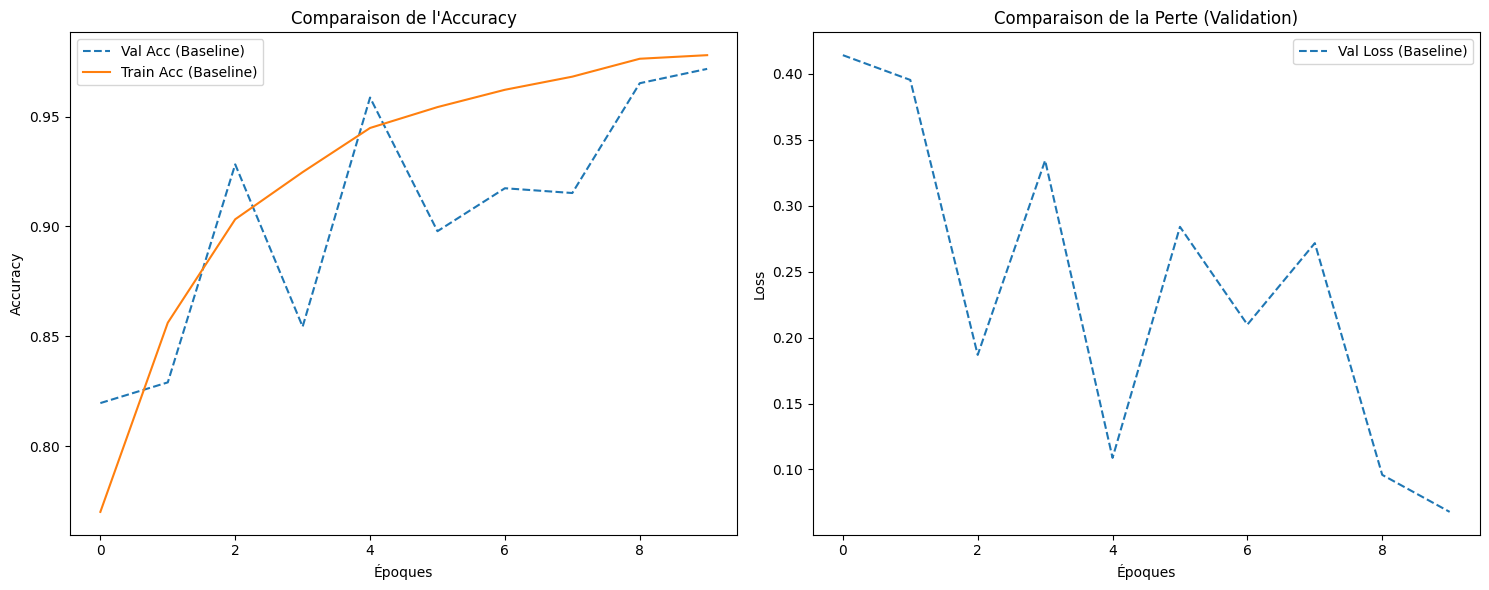

In [ ]:
def plot_comparison(histories, names):
    plt.figure(figsize=(15, 6))
    
    # Plot Accuracy
    plt.subplot(1, 2, 1)
    for hist, name in zip(histories, names):
        plt.plot(hist['val_acc'], label=f'Val Acc ({name})', linestyle='--')
        plt.plot(hist['train_acc'], label=f'Train Acc ({name})')
    plt.title('Comparaison de l\'Accuracy')
    plt.xlabel('Époques')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot Loss
    plt.subplot(1, 2, 2)
    for hist, name in zip(histories, names):
        plt.plot(hist['val_loss'], label=f'Val Loss ({name})', linestyle='--')
    plt.title('Comparaison de la Perte (Validation)')
    plt.xlabel('Époques')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.show()


# Appel de la fonction
plot_comparison(
    [history_res_base, history_res_gauss, history_res_rician], 
    ['Baseline', 'Gaussien', 'Ricien']
)

In [97]:
model_from_weights_base = BrainTumorResNet()
# Charger les poids
model_from_weights_base.load_state_dict(torch.load("weights_history_baseline/checkpoint_baseline_epoch_5.pth", map_location=torch.device('cpu')))

history = torch.load(
    "weights_history_baseline/baseline_history.pt",
    map_location=torch.device("cpu")
)


/Users/mathildebodet/Desktop/centrale/3A/Deep Learning/Pneumonia-Detection/venv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/mathildebodet/Desktop/centrale/3A/Deep Learning/Pneumonia-Detection/venv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


C:\Users\yoann\AppData\Local\Temp\ipykernel_7748\1092515601.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(['Healthy', 'Tumor'])
C:\Users\yoann\AppData\Local\Temp\ipykernel_7748\1092515601.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_yticklabels(['Healthy', 'Tumor'])
C:\Users\yoann\AppData\Local\Temp\ipykernel_7748\1092515601.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(['Healthy', 'Tumor'])
C:\Users\yoann\AppData\Local\Temp\ipykernel_7748\1092515601.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_yticklabels(['Healthy', 'Tumor'])
C:\Users\yoann\AppData\Local\T

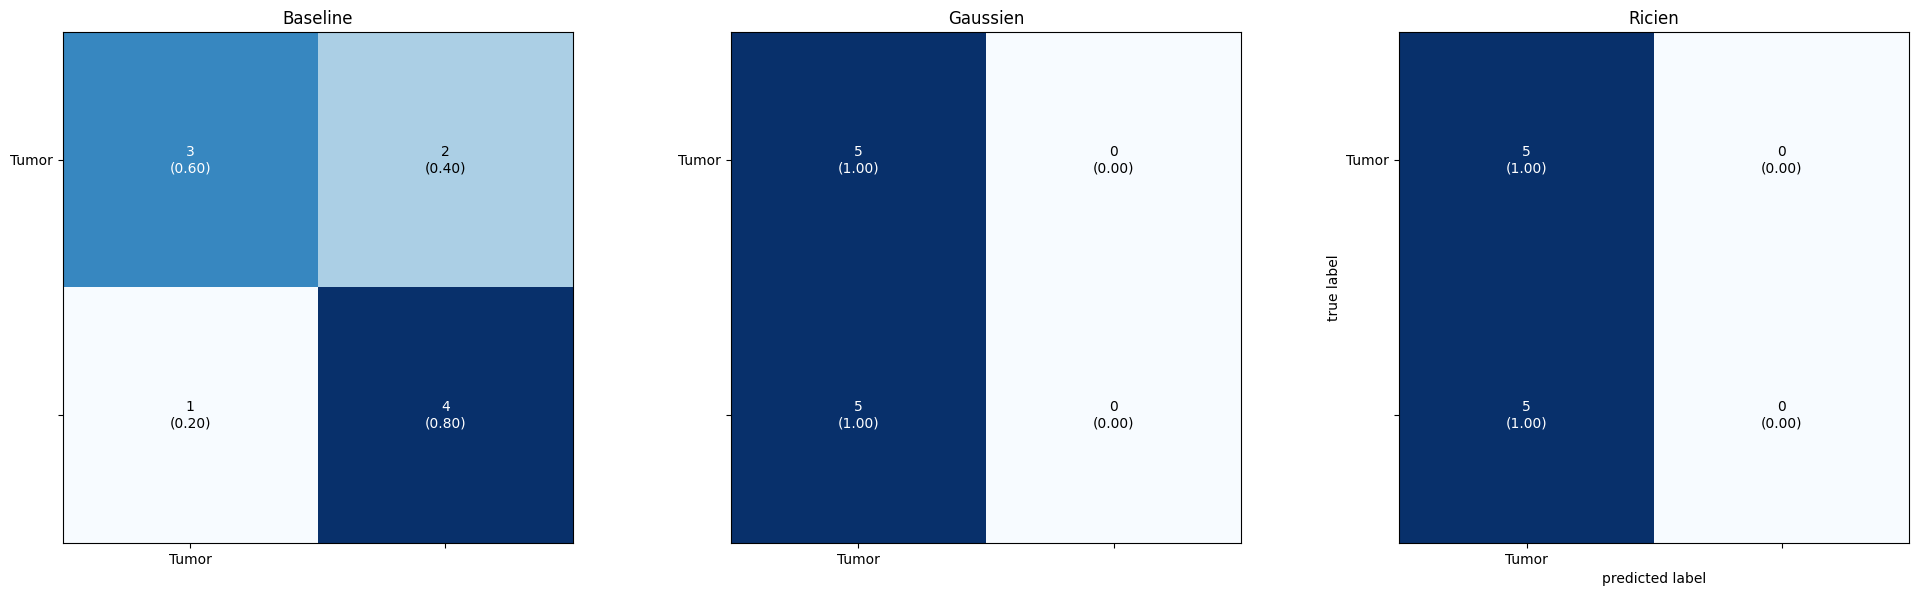

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
all_preds = [final_val_preds_base, final_val_preds_gauss, final_val_preds_rice]
titles = ['Baseline', 'Gaussien', 'Ricien']

for i, (p, t) in enumerate(zip(all_preds, [final_val_targets_base, final_val_targets_gauss, final_val_targets_rice])):
    cm = confusion_matrix(t, p)
    plot_confusion_matrix(conf_mat=cm, axis=axes[i], show_normed=True)
    axes[i].set_title(titles[i])
    axes[i].set_xticklabels(['Healthy', 'Tumor'])
    axes[i].set_yticklabels(['Healthy', 'Tumor'])

plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

def get_metrics(targets, preds, name):
    acc = accuracy_score(targets, preds)
    prec, rec, f1, _ = precision_recall_fscore_support(targets, preds, average='binary')
    return {'Scénario': name, 'Accuracy': acc, 'Precision': prec, 'Recall': rec, 'F1-Score': f1}

metrics_list = [
    get_metrics(final_val_targets_base, final_val_preds_base, 'Baseline'),
    get_metrics(final_val_targets_gauss, final_val_preds_gauss, 'Gaussien'),
    get_metrics(final_val_targets_rice, final_val_preds_rice, 'Ricien')
]

df_results = pd.DataFrame(metrics_list)
print(df_results)

   Scénario  Accuracy  Precision  Recall  F1-Score
0  Baseline       0.7   0.666667     0.8  0.727273
1  Gaussien       0.5   0.000000     0.0  0.000000
2    Ricien       0.5   0.000000     0.0  0.000000


c:\Users\yoann\OneDrive\Bureau\Cours 3A\SM10\Deep Learning\Pneumonia-Detection\env\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\yoann\OneDrive\Bureau\Cours 3A\SM10\Deep Learning\Pneumonia-Detection\env\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


## Prédictions

In [98]:
model_from_weights_base = BrainTumorResNet()
# Charger les poids
model_from_weights_base.load_state_dict(torch.load("weights_history_baseline/checkpoint_baseline_epoch_5.pth", map_location=torch.device('cpu')))

history_base = torch.load(
    "weights_history_baseline/baseline_history.pt",
    map_location=torch.device("cpu")
)

/Users/mathildebodet/Desktop/centrale/3A/Deep Learning/Pneumonia-Detection/venv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/mathildebodet/Desktop/centrale/3A/Deep Learning/Pneumonia-Detection/venv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [100]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_from_weights_base.to(device)

test_preds_base = []
test_targets_base = []

with torch.no_grad():
    for inputs, labels in test_dl:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model_from_weights_base(inputs)
        _, preds = torch.max(outputs, dim=1)

        test_preds_base.extend(preds.cpu().numpy().tolist())
        test_targets_base.extend(labels.cpu().numpy().tolist())


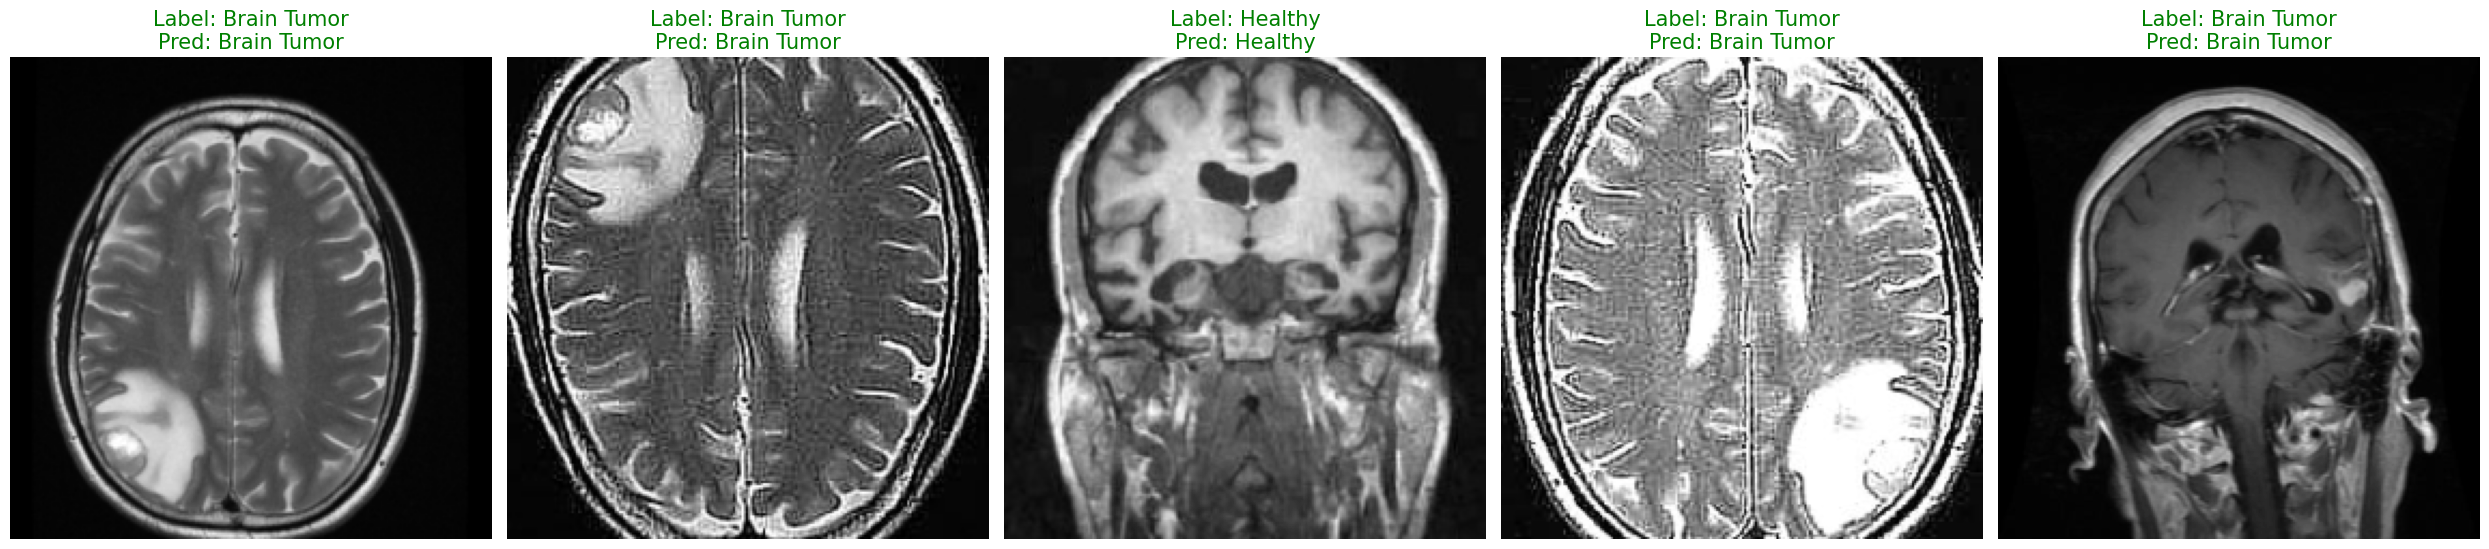

In [101]:
num_images = 5
idxs = random.sample(range(len(test_dataset)), num_images)

fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(25, 7))

for c, i in enumerate(idxs):
    img_tensor, label = test_dataset[i]
    
    ax[c].imshow(img_tensor[0, :, :], cmap='gray')
    
    actual_label = test_dataset.classes[label]
    predicted_label = test_dataset.classes[test_preds_base[i]] 
    
    ax[c].set_title(f'Label: {actual_label}\nPred: {predicted_label}', 
                    fontsize=15, 
                    color=('green' if actual_label == predicted_label else 'red'))
    
    ax[c].axis('off')

plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>

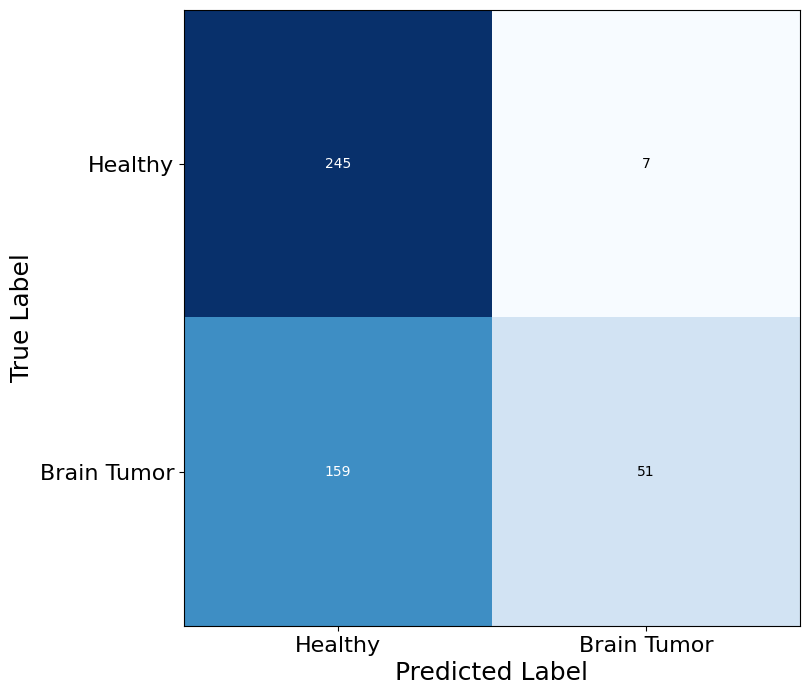

In [ ]:
plt.figure()

cm_conv = confusion_matrix(test_targets_base, test_preds_base)

plot_confusion_matrix(cm_conv, figsize=(12,8), cmap=plt.cm.Blues)

plt.xticks(range(2), ['Healthy', 'Brain Tumor'], fontsize=16)
plt.yticks(range(2), ['Healthy', 'Brain Tumor'], fontsize=16)

plt.xlabel('Predicted Label', fontsize=18)
plt.ylabel('True Label', fontsize=18)
plt.show()

# epoch 5

<Figure size 640x480 with 0 Axes>

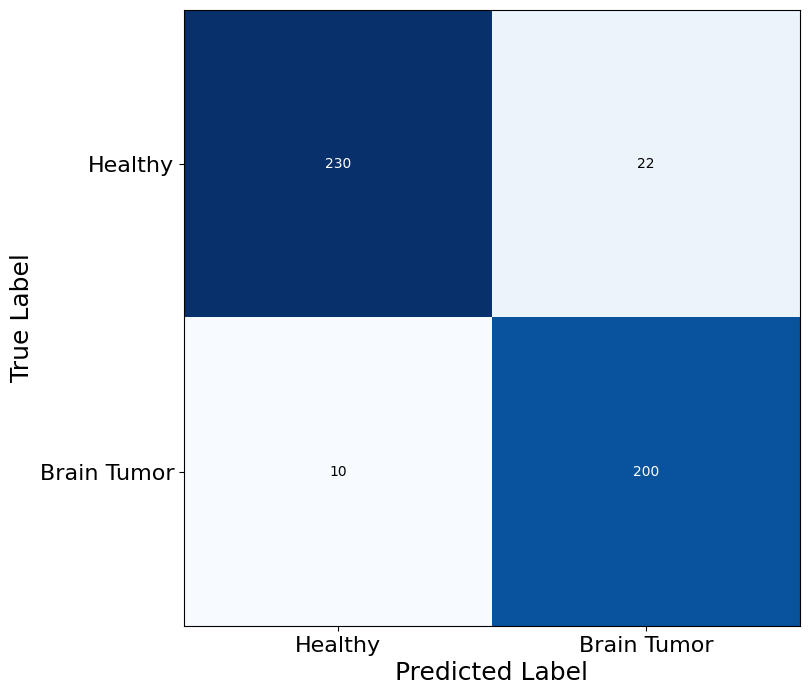

In [54]:
plt.figure()

cm_conv = confusion_matrix(test_targets, test_preds)

plot_confusion_matrix(cm_conv, figsize=(12,8), cmap=plt.cm.Blues)

plt.xticks(range(2), ['Healthy', 'Brain Tumor'], fontsize=16)
plt.yticks(range(2), ['Healthy', 'Brain Tumor'], fontsize=16)

plt.xlabel('Predicted Label', fontsize=18)
plt.ylabel('True Label', fontsize=18)
plt.show()

In [50]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(test_targets, test_preds)
print(cm)


[[245   7]
 [159  51]]


## gauss


In [102]:
model_from_weights_gauss = BrainTumorResNet()
# Charger les poids
model_from_weights_gauss.load_state_dict(torch.load("weights_history_gauss/checkpoint_gauss_epoch_10.pth", map_location=torch.device('cpu')))

history_gauss = torch.load(
    "weights_history_gauss/gauss_history.pt",
    map_location=torch.device("cpu")
)

/Users/mathildebodet/Desktop/centrale/3A/Deep Learning/Pneumonia-Detection/venv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/mathildebodet/Desktop/centrale/3A/Deep Learning/Pneumonia-Detection/venv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [103]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_from_weights_gauss.to(device)

test_preds_gauss = []
test_targets_gauss = []

with torch.no_grad():
    for inputs, labels in test_dl:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model_from_weights_gauss(inputs)
        _, preds = torch.max(outputs, dim=1)

        test_preds_gauss.extend(preds.cpu().numpy().tolist())
        test_targets_gauss.extend(labels.cpu().numpy().tolist())

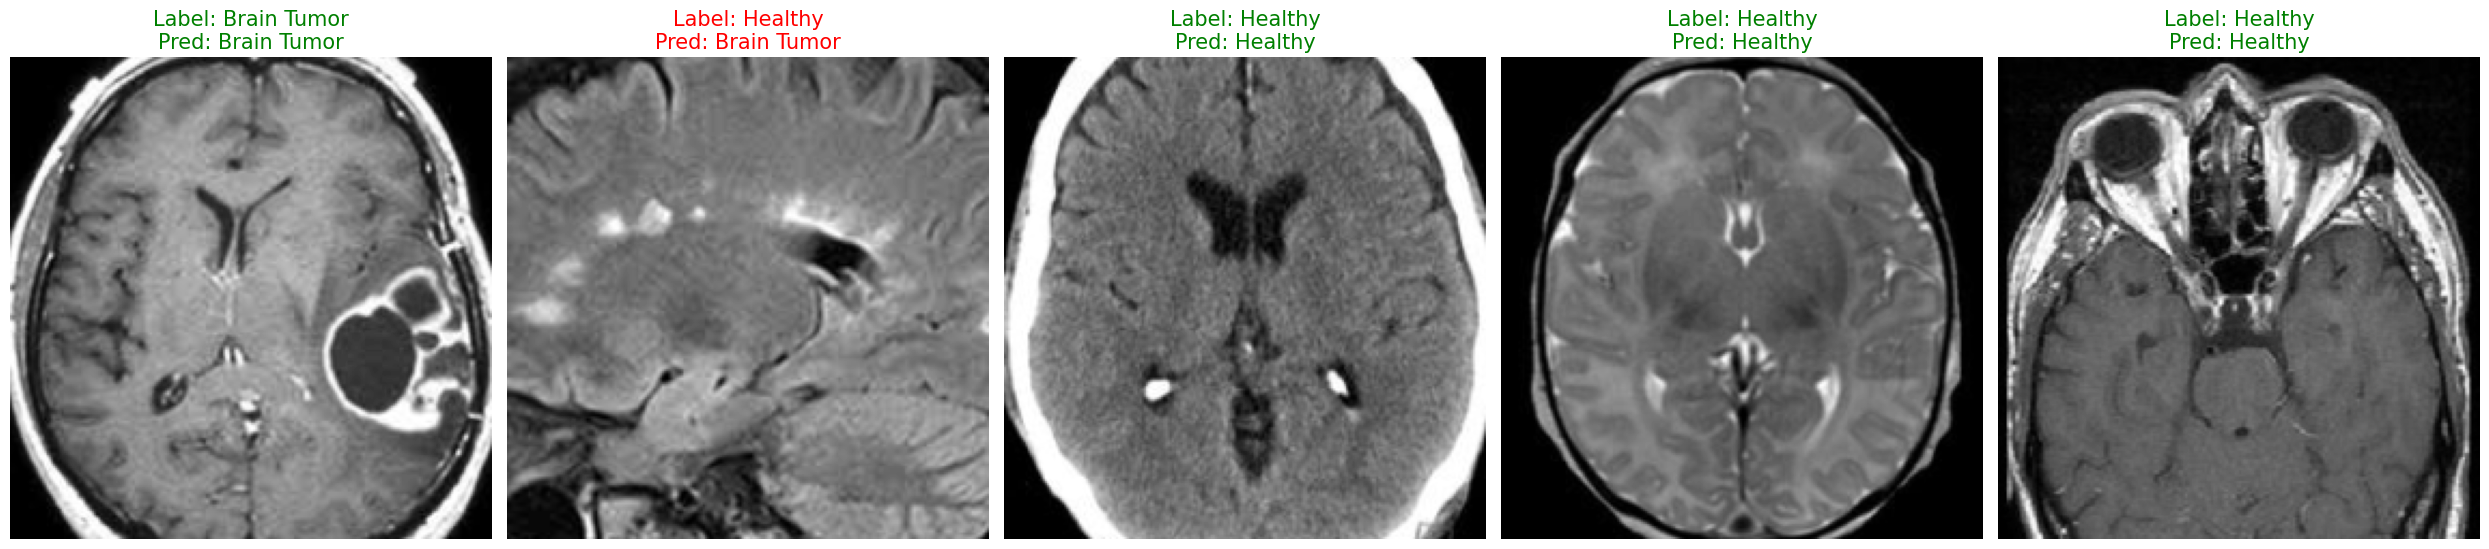

In [25]:
num_images = 5
idxs = random.sample(range(len(test_dataset)), num_images)

fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(25, 7))

for c, i in enumerate(idxs):
    img_tensor, label = test_dataset[i]
    
    ax[c].imshow(img_tensor[0, :, :], cmap='gray')
    
    actual_label = test_dataset.classes[label]
    predicted_label = test_dataset.classes[test_preds_gauss[i]] 
    
    ax[c].set_title(f'Label: {actual_label}\nPred: {predicted_label}', 
                    fontsize=15, 
                    color=('green' if actual_label == predicted_label else 'red'))
    
    ax[c].axis('off')

plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>

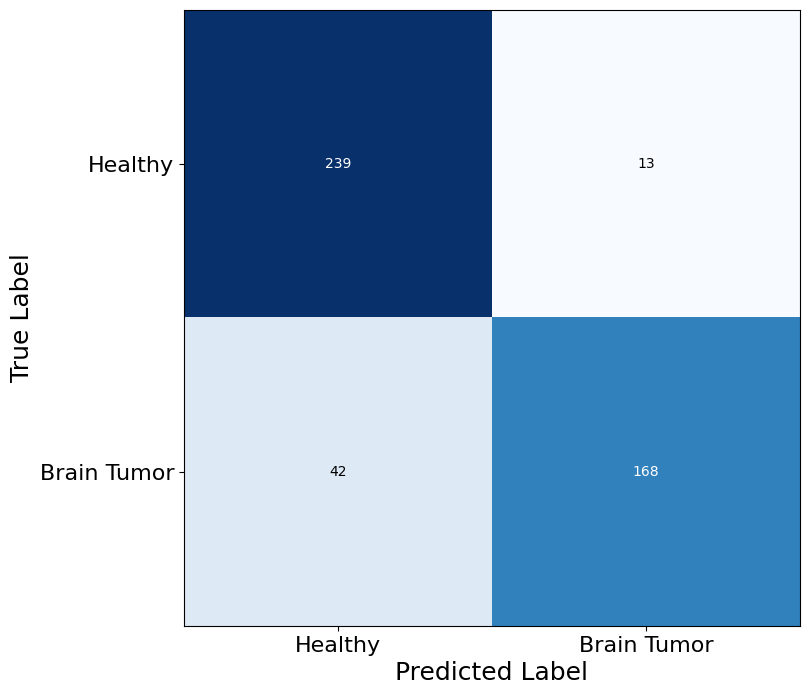

In [26]:
plt.figure()

cm_conv = confusion_matrix(test_targets_gauss, test_preds_gauss)

plot_confusion_matrix(cm_conv, figsize=(12,8), cmap=plt.cm.Blues)

plt.xticks(range(2), ['Healthy', 'Brain Tumor'], fontsize=16)
plt.yticks(range(2), ['Healthy', 'Brain Tumor'], fontsize=16)

plt.xlabel('Predicted Label', fontsize=18)
plt.ylabel('True Label', fontsize=18)
plt.show()

## Epoch 10

<Figure size 640x480 with 0 Axes>

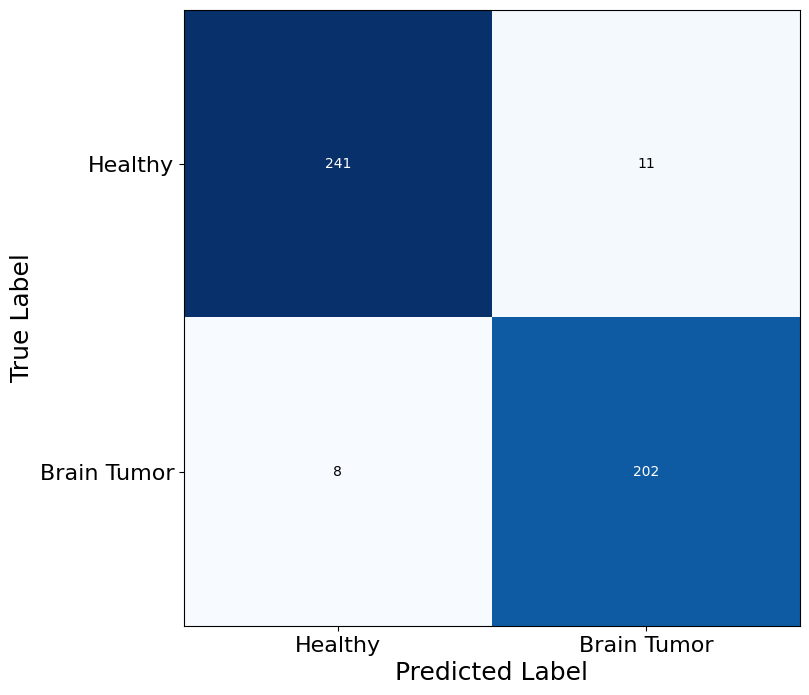

In [29]:
plt.figure()

cm_conv = confusion_matrix(test_targets_gauss, test_preds_gauss)

plot_confusion_matrix(cm_conv, figsize=(12,8), cmap=plt.cm.Blues)

plt.xticks(range(2), ['Healthy', 'Brain Tumor'], fontsize=16)
plt.yticks(range(2), ['Healthy', 'Brain Tumor'], fontsize=16)

plt.xlabel('Predicted Label', fontsize=18)
plt.ylabel('True Label', fontsize=18)
plt.show()

## Rician

In [104]:
model_from_weights_rice = BrainTumorResNet()
# Charger les poids
model_from_weights_rice.load_state_dict(torch.load("weights_history_rician/checkpoint_rice_epoch_10.pth", map_location=torch.device('cpu')))

history_rice = torch.load(
    "weights_history_rician/rice_history.pt",
    map_location=torch.device("cpu")
)

/Users/mathildebodet/Desktop/centrale/3A/Deep Learning/Pneumonia-Detection/venv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/mathildebodet/Desktop/centrale/3A/Deep Learning/Pneumonia-Detection/venv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [105]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_from_weights_rice.to(device)

test_preds_rice = []
test_targets_rice = []

with torch.no_grad():
    for inputs, labels in test_dl:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model_from_weights_rice(inputs)
        _, preds = torch.max(outputs, dim=1)

        test_preds_rice.extend(preds.cpu().numpy().tolist())
        test_targets_rice.extend(labels.cpu().numpy().tolist())

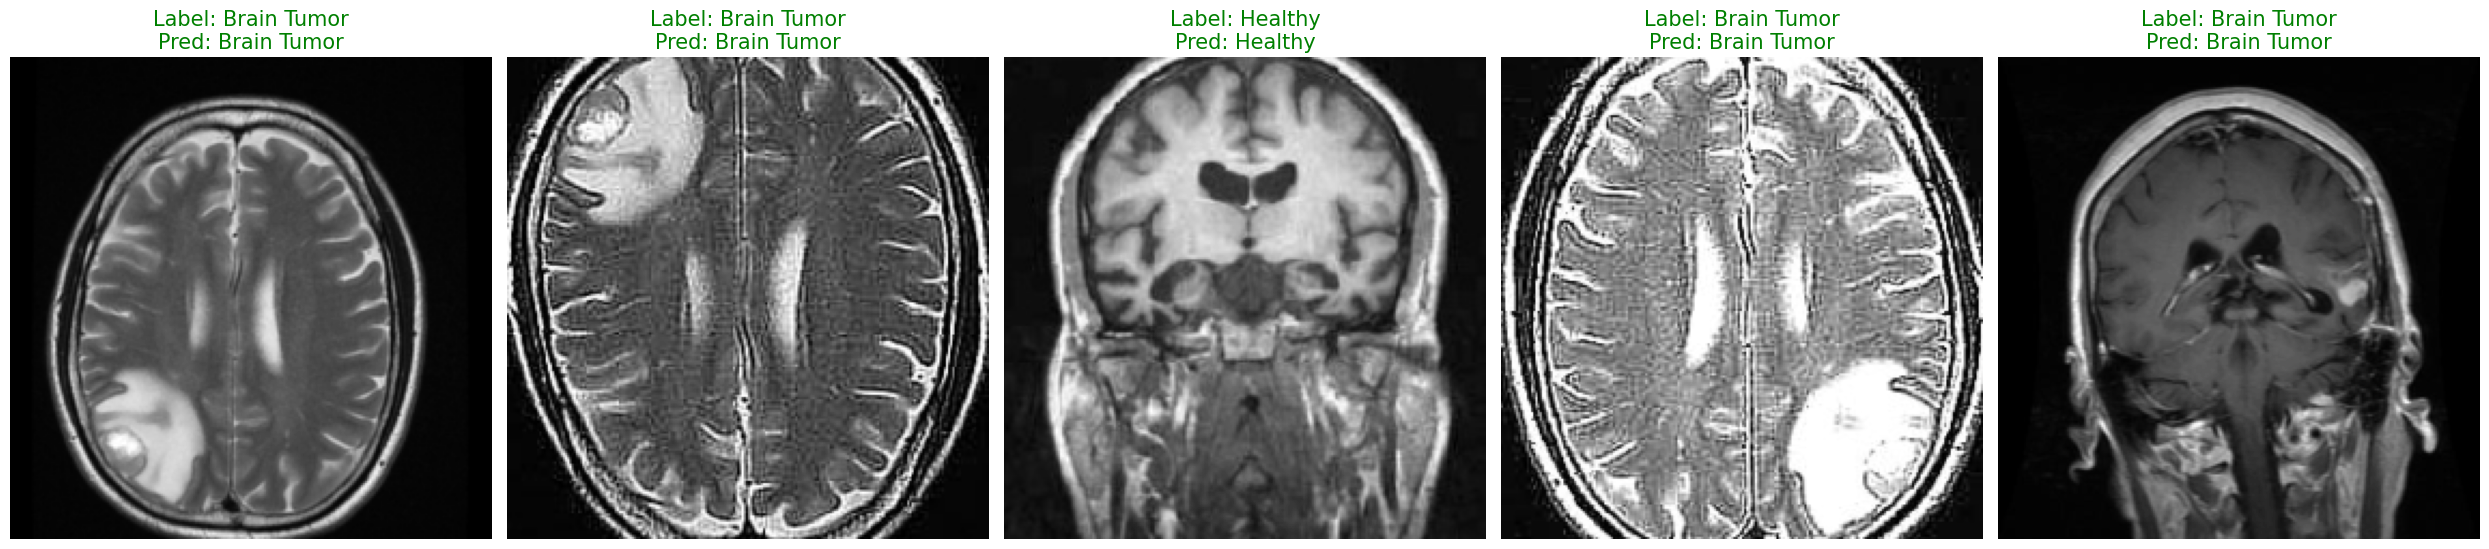

In [41]:
num_images = 5
idxs = random.sample(range(len(test_dataset)), num_images)

fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(25, 7))

for c, i in enumerate(idxs):
    img_tensor, label = test_dataset[i]
    
    ax[c].imshow(img_tensor[0, :, :], cmap='gray')
    
    actual_label = test_dataset.classes[label]
    predicted_label = test_dataset.classes[test_preds_rice[i]] 
    
    ax[c].set_title(f'Label: {actual_label}\nPred: {predicted_label}', 
                    fontsize=15, 
                    color=('green' if actual_label == predicted_label else 'red'))
    
    ax[c].axis('off')

plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>

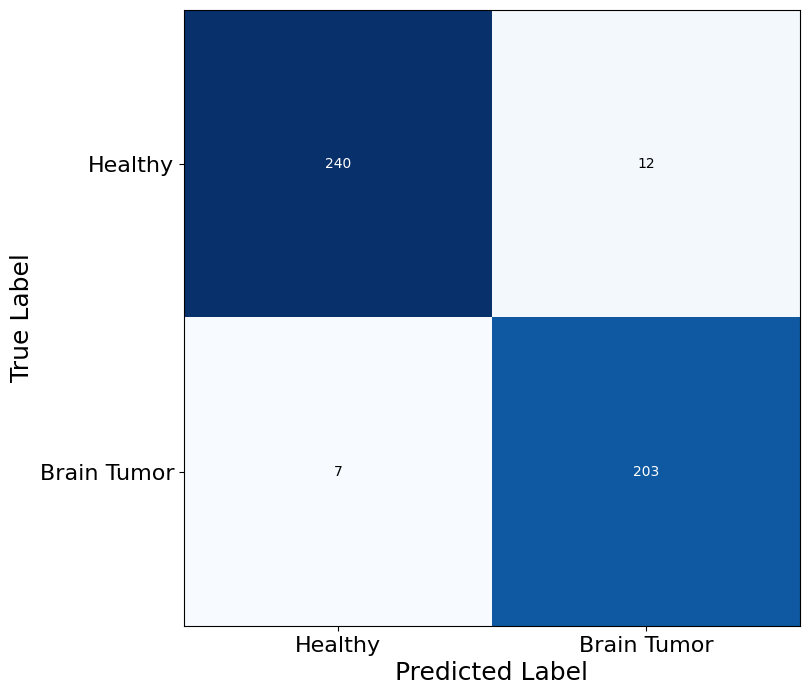

In [42]:
plt.figure()

cm_conv = confusion_matrix(test_targets_rice, test_preds_rice)

plot_confusion_matrix(cm_conv, figsize=(12,8), cmap=plt.cm.Blues)

plt.xticks(range(2), ['Healthy', 'Brain Tumor'], fontsize=16)
plt.yticks(range(2), ['Healthy', 'Brain Tumor'], fontsize=16)

plt.xlabel('Predicted Label', fontsize=18)
plt.ylabel('True Label', fontsize=18)
plt.show()

## Epoch 5

<Figure size 640x480 with 0 Axes>

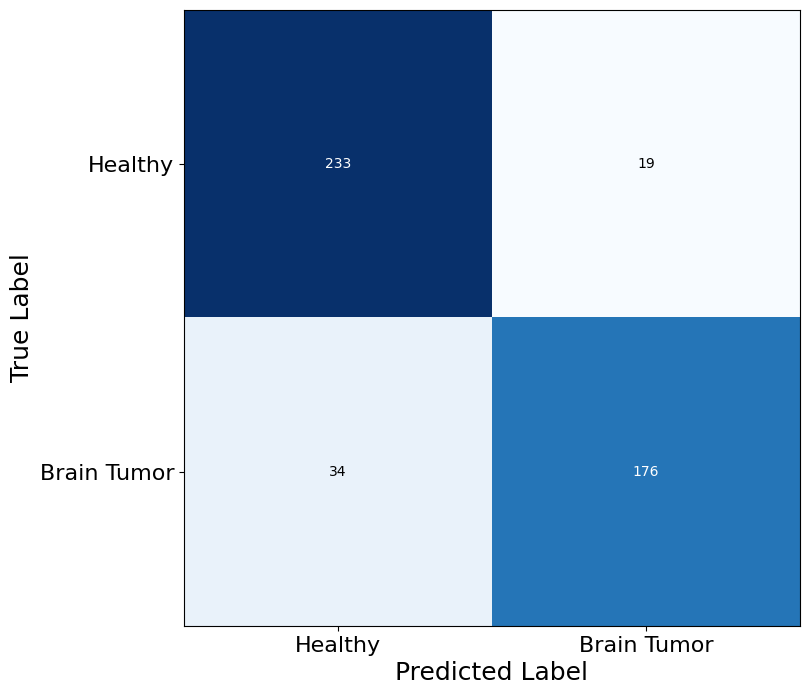

In [36]:
plt.figure()

cm_conv = confusion_matrix(test_targets_rice, test_preds_rice)

plot_confusion_matrix(cm_conv, figsize=(12,8), cmap=plt.cm.Blues)

plt.xticks(range(2), ['Healthy', 'Brain Tumor'], fontsize=16)
plt.yticks(range(2), ['Healthy', 'Brain Tumor'], fontsize=16)

plt.xlabel('Predicted Label', fontsize=18)
plt.ylabel('True Label', fontsize=18)
plt.show()

## Comparison

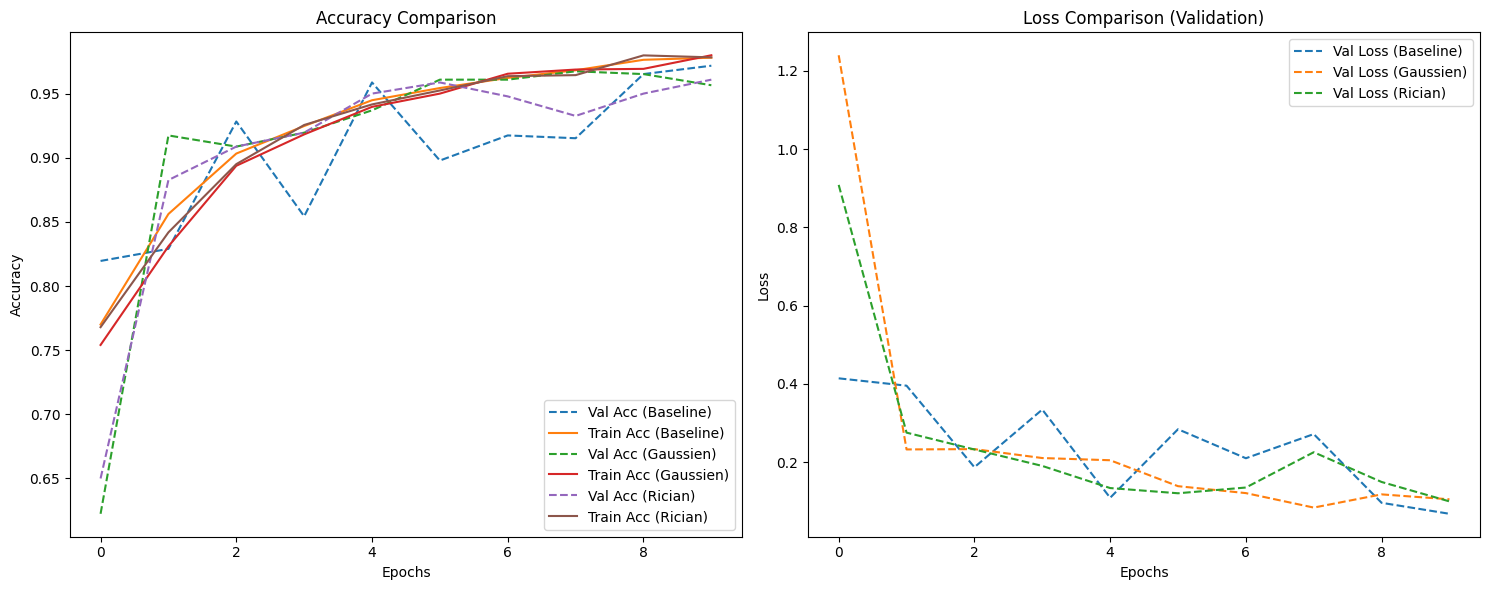

In [108]:
def plot_comparison(histories, names):
    plt.figure(figsize=(15, 6))
    
    # Plot Accuracy
    plt.subplot(1, 2, 1)
    for hist, name in zip(histories, names):
        plt.plot(hist['val_acc'], label=f'Val Acc ({name})', linestyle='--')
        plt.plot(hist['train_acc'], label=f'Train Acc ({name})')
    plt.title('Accuracy Comparison')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot Loss
    plt.subplot(1, 2, 2)
    for hist, name in zip(histories, names):
        plt.plot(hist['val_loss'], label=f'Val Loss ({name})', linestyle='--')
    plt.title('Loss Comparison (Validation)')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.show()


# Appel de la fonction
plot_comparison(
    [history_base, history_gauss, history_rice], 
    ['Baseline', 'Gaussien', 'Rician']
)

/var/folders/6f/0n_tx1_52_j72w8klppsd8qc0000gn/T/ipykernel_4075/2261375207.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(['Healthy', 'Tumor'])
/var/folders/6f/0n_tx1_52_j72w8klppsd8qc0000gn/T/ipykernel_4075/2261375207.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_yticklabels(['Healthy', 'Tumor'])
/var/folders/6f/0n_tx1_52_j72w8klppsd8qc0000gn/T/ipykernel_4075/2261375207.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(['Healthy', 'Tumor'])
/var/folders/6f/0n_tx1_52_j72w8klppsd8qc0000gn/T/ipykernel_4075/2261375207.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_ytic

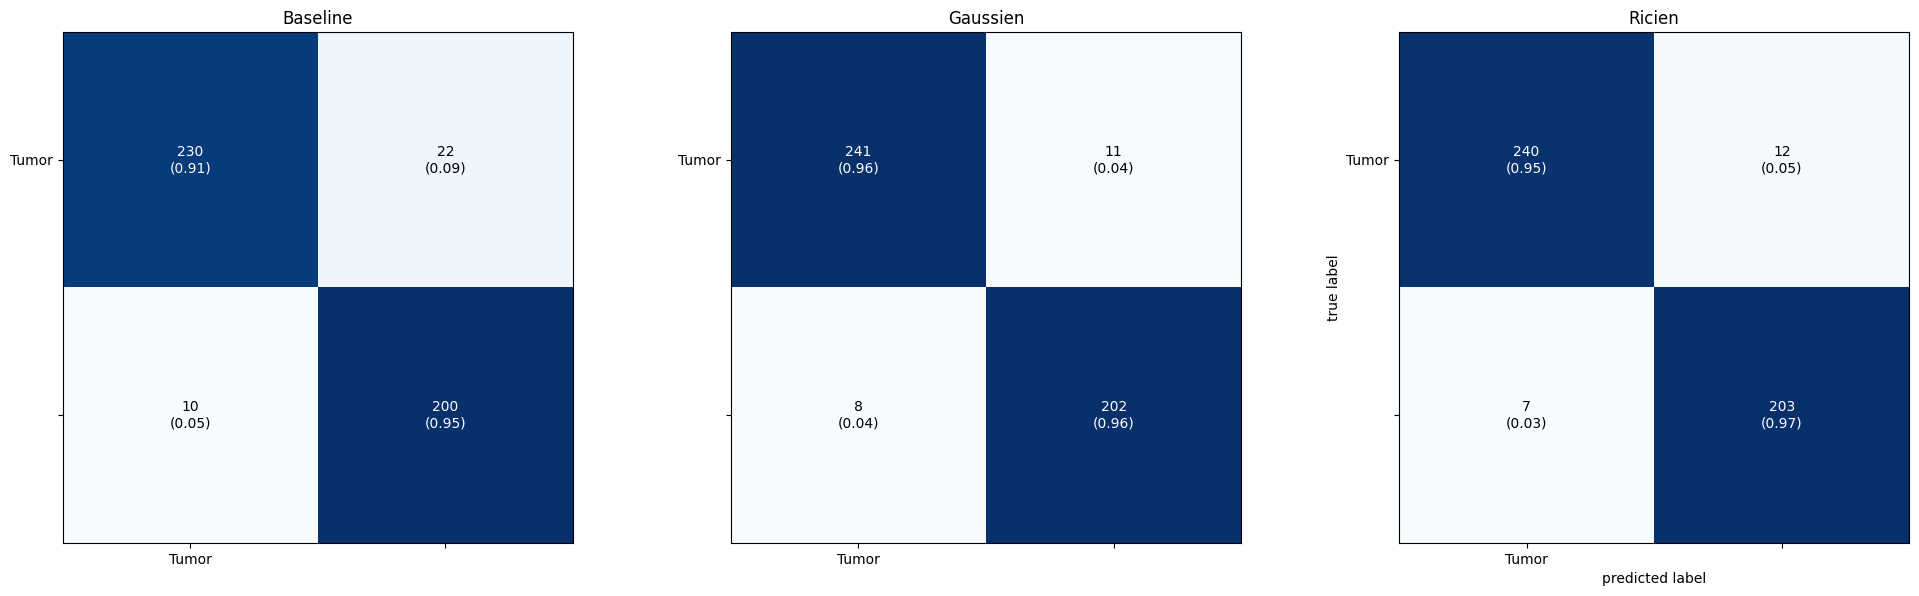

In [107]:
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
all_preds = [test_preds_base, test_preds_gauss, test_preds_rice]
titles = ['Baseline', 'Gaussien', 'Ricien']

for i, (p, t) in enumerate(zip(all_preds, [test_targets_base, test_targets_gauss, test_targets_rice])):
    cm = confusion_matrix(t, p)
    plot_confusion_matrix(conf_mat=cm, axis=axes[i], show_normed=True)
    axes[i].set_title(titles[i])
    axes[i].set_xticklabels(['Healthy', 'Tumor'])
    axes[i].set_yticklabels(['Healthy', 'Tumor'])

plt.tight_layout()
plt.show()

In [1]:
import gc
import torch
gc.collect()
torch.cuda.empty_cache()
torch.mps.empty_cache()

# DenseNet

In [68]:
import torch.nn as nn
from torchvision import models

class BrainTumorDenseNet(nn.Module):
    def __init__(self):
        super().__init__()

        # 🔹 Pretrained DenseNet (ImageNet)
        self.network = models.densenet121(pretrained=True)

        # 🔹 Geler tout le backbone
        for param in self.network.features.parameters():
            param.requires_grad = False

        # 🔹 Remplacer le classifier
        num_features = self.network.classifier.in_features
        self.network.classifier = nn.Linear(num_features, 2)

    def forward(self, x):
        return self.network(x)


In [77]:
n_epochs = 10

# 1. Entraînement Baseline
print("\n--- Training DenseNet: BASELINE ---")
model_dense_base = BrainTumorDenseNet()
history_dense_base,final_val_preds_base,final_val_targets_base = train_scenario(model_dense_base, train_loader_base, val_loader,n_epochs=n_epochs)


--- Training DenseNet: BASELINE ---
Epoch 1/10 - Loss: 0.5198 - Acc: 0.7393 | Val Acc: 0.7949
Epoch 2/10 - Loss: 0.4532 - Acc: 0.7924 | Val Acc: 0.7130
Epoch 3/10 - Loss: 0.4228 - Acc: 0.8056 | Val Acc: 0.8384
Epoch 4/10 - Loss: 0.4172 - Acc: 0.8078 | Val Acc: 0.7957
Epoch 5/10 - Loss: 0.4051 - Acc: 0.8139 | Val Acc: 0.7978
Epoch 6/10 - Loss: 0.4084 - Acc: 0.8024 | Val Acc: 0.8000
Epoch 7/10 - Loss: 0.3997 - Acc: 0.8171 | Val Acc: 0.8000
Epoch 8/10 - Loss: 0.4008 - Acc: 0.8204 | Val Acc: 0.8087
Epoch 9/10 - Loss: 0.3961 - Acc: 0.8142 | Val Acc: 0.8174
Epoch 10/10 - Loss: 0.3882 - Acc: 0.8252 | Val Acc: 0.8457


In [78]:
import torch

torch.save(model_dense_base.state_dict(), "densenet121_brain_tumor_weights_baseline.pth")


In [79]:
torch.save(history, "densenet_base_history.pt")
torch.save(
    {
        "val_preds": final_val_preds_base,
        "val_targets": final_val_targets_base
    },
    "validation_outputs_epoch10_densenet_baseline.pt"
)

In [84]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_dense_base.to(device)

test_preds_dense = []
test_targets_dense = []

with torch.no_grad():
    for inputs, labels in test_dl:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model_dense_base(inputs)
        _, preds = torch.max(outputs, dim=1)

        test_preds_dense.extend(preds.cpu().numpy().tolist())
        test_targets_dense.extend(labels.cpu().numpy().tolist())

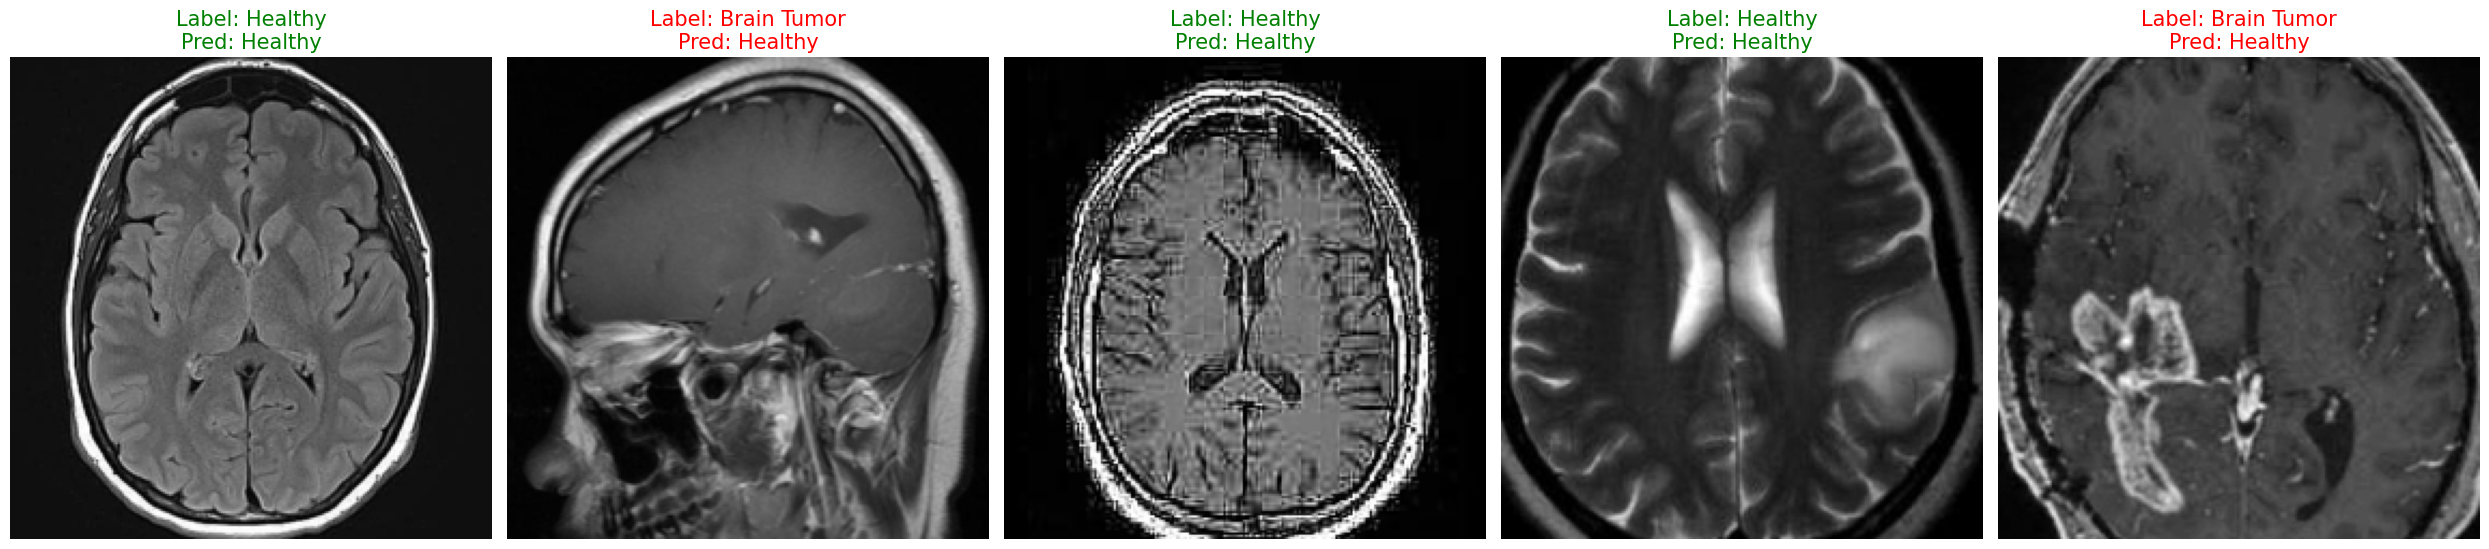

In [85]:
num_images = 5
idxs = random.sample(range(len(test_dataset)), num_images)

fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(25, 7))

for c, i in enumerate(idxs):
    img_tensor, label = test_dataset[i]
    
    ax[c].imshow(img_tensor[0, :, :], cmap='gray')
    
    actual_label = test_dataset.classes[label]
    predicted_label = test_dataset.classes[test_preds_dense[i]] 
    
    ax[c].set_title(f'Label: {actual_label}\nPred: {predicted_label}', 
                    fontsize=15, 
                    color=('green' if actual_label == predicted_label else 'red'))
    
    ax[c].axis('off')

plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>

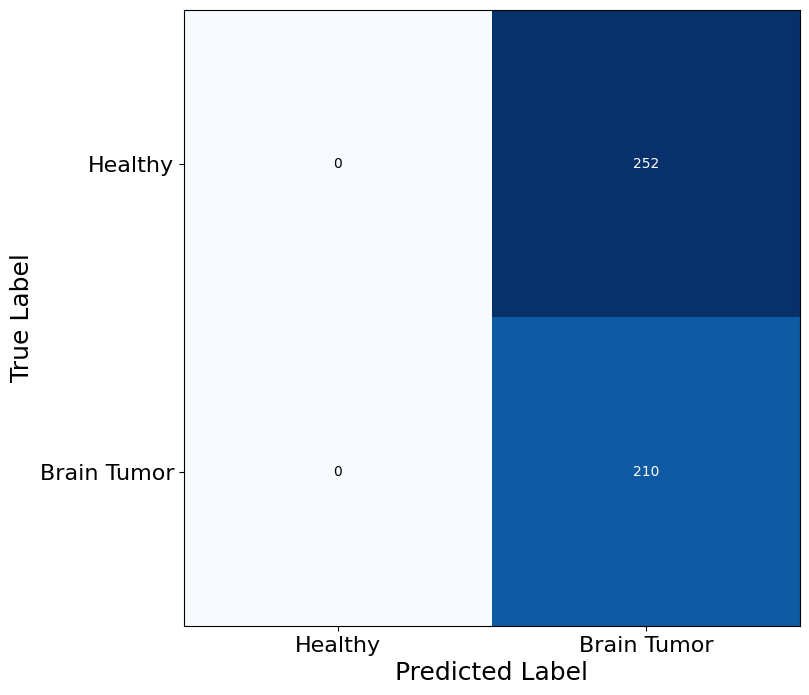

In [86]:
plt.figure()

cm_conv = confusion_matrix(test_targets_dense, test_preds_dense)

plot_confusion_matrix(cm_conv, figsize=(12,8), cmap=plt.cm.Blues)

plt.xticks(range(2), ['Healthy', 'Brain Tumor'], fontsize=16)
plt.yticks(range(2), ['Healthy', 'Brain Tumor'], fontsize=16)

plt.xlabel('Predicted Label', fontsize=18)
plt.ylabel('True Label', fontsize=18)
plt.show()